# Data Analysis Project of fontanka.ru Website

### Imports

In [1]:
import re
import time
import datetime

import nltk
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

from tqdm import tqdm
from bs4 import BeautifulSoup
from selenium import webdriver
from dataclasses import dataclass
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords

nltk.download("stopwords")

sns.set(style="darkgrid")
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mivan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Part 1.1
## Parser Implementation

### Parser

In [34]:
def get_page(p) -> list:
    """A function to retrieve data from a web page."""

    # Generating the url for the request
    url = f'https://www.fontanka.ru/{p}/all.html'
    
    # Receiving a response from the server
    response = requests.get(url)

    # Convert the response to a BeautifulSoup object
    tree = BeautifulSoup(response.content, 'html.parser')
    
    # Find all the news for the day
    news = tree.find_all('li', {'class' : 'KXak5'})
    
    info = []

    # Going around every news item
    for post in news:
        title = post.find('div', class_="KXalh").find('a', class_="KXb1")
        if title:
            title = title.text
        else:
            title = "?"
        
        topic = post.find('a').get('title')
        link = post.find('div', class_="KXalh").find('a', class_="KXb1").get('href')
        time = post.find('time', {'class': 'KXcn'})
        if time and time.find('span'):
            time = time.text
        else:
            time = '?'
    
        comm_element = post.find('a', {'class': 'L9c3 L9acx KXc3'})
        if comm_element and comm_element.find('span'):
            comm = comm_element.find('span').text
        else:
            comm = "?"

        if "doctorpiter.ru" in link:
            urli = link
        else:
            if "https://www.fontanka.ru" in link:
                urli = link
            else:
                urli = 'https://www.fontanka.ru' + link

        # Going inside each news item we found
        response_inner = requests.get(urli)
        tree_inner = BeautifulSoup(response_inner.content, 'html.parser')

        # If this is affiliate news from doctorpiter.ru website
        if "doctorpiter.ru" in urli:
            new = tree_inner.find('section', {'class' : "ds-article-content"})
            badauthor = tree_inner.find('div', {'class' : "ds-article-footer"})
            if badauthor:
                badauthor = badauthor.text
                match = re.search(r':(.+)', badauthor)
                if match:
                    author = match.group(1)
                else:
                    author = badauthor
            else:
                author = "?"

            views = '?' # This site does not have a view counter
            if new:
                content = new.text
            else:
                content = "?"

        else:
            # If this is news from fontanka.ru
            if "https://www.fontanka.ru" in urli:
                content = tree_inner.find('div', {'class' : 'B-b9'})
                views = tree_inner.find('div', {'class' : 'A7gp'})
                author = tree_inner.find('div', {'class' : "ALe1"})
                if views and views.find('span'):
                    views = views.text
                if author:
                    author = author.text
                if content:
                    content = content.text
            else:
                author = "?"
                views = "?"
                content = "?"

        row = {
            'date': p,
            'title': title,
            'topic': topic,
            'url': urli,
            'time': time,
            'comm_num': comm,
            'author': author,
            'views': views,
            'content': content
            }

        info.append(row)
    
    return info

### Data Collection

In [ ]:
"""
Passing through links in format:
'https://www.fontanka.ru/{p}/all.html'
"""

infa = []
for yy in range(2023, 2002, -1):
    for mm in range(12, 0, -1):
        for dd in range(31, 0, -1):
            p = f'{yy:04}/{mm:02}/{dd:02}'
            try:
                infa.extend(get_page(p))
                df = pd.DataFrame(infa)
                df.to_csv('news.csv', index=False, mode='a')
                infa = []
                
            except Exception as e:
                print(f"Failed to get data for: {p}. Exception: {e}")
                pass

With the help of this parser, we were able to extract data for almost 5 years (12.12.2018 - 20.10.2023).

## Part 1.2
## Exploratory Data Analysis

### Data Preparation

In [88]:
df = pd.read_csv('news.csv')
df.shape

(127359, 9)

In [81]:
df.head()

date                                              title  \
0  2023/10/20  В Нижегородской области мужчина убил друга, ур...   
1  2023/10/20       Дело Дарьи Треповой* зарегистрировано в суде   
2  2023/10/20  Пора менять резину. Дорожники Ленобласти дают ...   
3  2023/10/20  «Интифада будет». Медведев высказался о послед...   
4  2023/10/20  Они не работают: врач рассказал о трех бесполе...   

          topic                                                url   time  \
0  Происшествия       https://www.fontanka.ru/2023/10/20/72831047/  12:51   
1  Происшествия       https://www.fontanka.ru/2023/10/20/72831212/  12:48   
2          Авто       https://www.fontanka.ru/2023/10/20/72830423/  12:45   
3      Общество       https://www.fontanka.ru/2023/10/20/72830546/  12:34   
4  Доктор Питер  https://doctorpiter.ru/obraz-zhizni/oni-ne-rab...  12:30   

  comm_num                       author views  \
0        ?                Федор Данилов    21   
1        ?             Мазакина Надежда   161   
2        ?                Яковлева Юлия   400   
3       12  Елена Маньковакорреспондент  1082   
4        ?                 Анна Майская     ?   

                                             content  
0  В Нижегородской области осудили мужчину на пол...  
1  Уголовное дело о терроризме поступило во Второ...  
2  Дорожный комитет Ленобласти 20 октября предлаг...  
3  Зампред Совбеза РФ Дмитрий Медведев высказался...  
4  Источник:\nunsplashКак убрать выпирающий или н...

#### Handling missing and erroneous values

Let's start handling missing values in articles and headlines.

In [89]:
df[df['content'] == '?']

date                                              title  \
3922   2023/08/24  «Надо просто меньше есть». Почему такие советы...   
4071   2023/08/23  Наш проект: «Я только кусочек». Как похудеть т...   
4151   2023/08/22  Наш проект: Бариатрические операции. Когда и з...   
4413   2023/08/18  Может спасти тысячи жизней: ученые рассказали ...   
4426   2023/08/18  Мужчина уже 8 лет ходит исключительно босиком,...   
...           ...                                                ...   
87048  2020/09/29  6 причин выбрать Финляндию для лечения рака гр...   
87242  2020/09/27  Наш проект: Даже эпидемия не мешает. Онкологич...   
87622  2020/09/23  Наш проект: Не теряя времени. Как попасть на л...   
87655  2020/09/21  Вакансия: «Доктор Питер» ищет выпускающего ред...   
88722  2020/09/01  Россиянин, который каждый год проходил флюорог...   

              topic                                                url   time  \
3922       Общество  https://doctorpiter.ru/sp/poslednii-rubezh-kog...  21:00   
4071       Общество  https://doctorpiter.ru/sp/poslednii-rubezh-kog...  18:00   
4151       Общество  https://doctorpiter.ru/sp/poslednii-rubezh-kog...  18:00   
4413   Доктор Питер  https://doctorpiter.ru/novosti/eto-mozhet-spas...  14:50   
4426   Доктор Питер  https://doctorpiter.ru/zdorove/muzhchina-uzhe-...  13:29   
...             ...                                                ...    ...   
87048      Общество  https://doctorpiter.ru/longreads/6-prichin-vib...  17:08   
87242         Город  https://doctorpiter.ru/longreads/6-prichin-vib...  12:00   
87622         Город  https://doctorpiter.ru/longreads/6-prichin-vib...  15:00   
87655  Доктор Питер             https://doctorpiter.ru/articles/26447/  19:25   
88722  Доктор Питер             https://doctorpiter.ru/articles/26338/  17:34   

      comm_num author views content  
3922         ?      ?     ?       ?  
4071         ?      ?     ?       ?  
4151         ?      ?     ?       ?  
4413         ?      ?     ?       ?  
4426         ?      ?     ?       ?  
...        ...    ...   ...     ...  
87048        ?      ?     ?       ?  
87242        ?      ?     ?       ?  
87622        ?      ?     ?       ?  
87655        ?      ?     ?       ?  
88722        ?      ?     ?       ?  

[162 rows x 9 columns]

We see that the parser failed to capture the text of 162 news. It will be harmless for our project if we delete these rows.

In [90]:
df = df[df['content'] != '?']

In [91]:
len(df[df['title'] == '?'])

0

In [92]:
df['content'].isnull().sum()

2742

We found another 2742 empty values.

In [93]:
df.dropna(subset=['content'], inplace=True)

In [94]:
df['content'].isnull().sum()

0

In [95]:
df['title'].isnull().sum()

0

There are no missing values in the headings.

Let's handle missing values in urls and topics.

In [96]:
len(df[df['url'] == '?'])

0

In [97]:
len(df[df['topic'] == '?'])

0

In [98]:
df['url'].isnull().sum()

0

In [99]:
df['topic'].isnull().sum()

235

There are no missing values in the `url` column. But there are 235 missings in the `topic` column.

In [100]:
df.dropna(subset=['topic'], inplace=True)

In [101]:
df['topic'].isnull().sum()

0

Check date and time for missings, bring to correct format.

In [102]:
len(df[df['time'] == '?'])

0

In [103]:
df['time'].isnull().sum()

0

In [104]:
len(df[df['date'] == '?'])

0

In [105]:
df['date'].isnull().sum()

0

In [106]:
for x in df['date'].unique():
    print(x)

2023/10/20
date
2023/10/19
2023/10/18
2023/10/17
2023/10/16
2023/10/15
2023/10/14
2023/10/13
2023/10/12
2023/10/11
2023/10/08
2023/10/06
2023/10/01
2023/09/31
2023/09/30
2023/09/26
2023/09/25
2023/09/24
2023/09/23
2023/09/22
2023/09/21
2023/09/20
2023/09/19
2023/09/18
2023/09/17
2023/09/16
2023/09/15
2023/09/14
2023/09/13
2023/09/12
2023/09/11
2023/09/09
2023/09/08
2023/09/07
2023/09/06
2023/09/05
2023/09/04
2023/08/31
2023/08/29
2023/08/28
2023/08/27
2023/08/26
2023/08/25
2023/08/24
2023/08/23
2023/08/22
2023/08/20
2023/08/19
2023/08/18
2023/08/17
2023/08/16
2023/08/15
2023/08/13
2023/08/12
2023/08/11
2023/08/10
2023/08/09
2023/08/08
2023/08/07
2023/08/06
2023/08/05
2023/08/04
2023/08/03
2023/08/02
2023/08/01
2023/07/31
2023/07/30
2023/07/29
2023/07/28
2023/07/27
2023/07/26
2023/07/25
2023/07/24
2023/07/23
2023/07/21
2023/07/20
2023/07/19
2023/07/18
2023/07/15
2023/07/14
2023/07/13
2023/07/12
2023/07/11
2023/07/07
2023/07/05
2023/07/01
2023/06/31
2023/06/30
2023/06/27
2023/06/26
2023/

We see that we parsed the wrong value in the “date” column - “date”.

In [107]:
df = df[df['date'] != 'date']

The Fontanka.ru website is designed in such a way that it supports navigation to URLs containing non-existent days. For example, when clicking on the link: https://www.fontanka.ru/2023/09/31 (the day 2023/09/31 does not exist in the calendar), we will be taken to a page with news for 2023/10/01. Let's handle these cases manually

In [108]:
df['date'] = df['date'].replace('2023/09/31', '2023/10/01')
df['date'] = df['date'].replace('2023/06/31', '2023/07/01')
df['date'] = df['date'].replace('2023/04/31', '2023/05/01')
df['date'] = df['date'].replace('2023/02/31', '2023/03/01')
df['date'] = df['date'].replace('2023/02/30', '2023/03/01')
df['date'] = df['date'].replace('2023/02/29', '2023/03/01')

df['date'] = df['date'].replace('2022/11/31', '2022/12/01')
df['date'] = df['date'].replace('2022/06/31', '2022/07/01')
df['date'] = df['date'].replace('2022/04/31', '2022/05/01')
df['date'] = df['date'].replace('2022/02/31', '2022/03/01')
df['date'] = df['date'].replace('2022/02/30', '2022/03/01')
df['date'] = df['date'].replace('2022/02/29', '2022/03/01')

df['date'] = df['date'].replace('2021/11/31', '2021/12/01')
df['date'] = df['date'].replace('2021/09/31', '2021/10/01')
df['date'] = df['date'].replace('2021/04/31', '2021/05/01')
df['date'] = df['date'].replace('2021/02/31', '2021/03/01')
df['date'] = df['date'].replace('2021/02/30', '2021/03/01')
df['date'] = df['date'].replace('2021/02/29', '2021/03/01')

df['date'] = df['date'].replace('2020/11/31', '2020/12/01')

df['date'] = df['date'].replace('2019/11/31', '2019/12/01')
df['date'] = df['date'].replace('2019/09/31', '2019/10/01')
df['date'] = df['date'].replace('2019/06/31', '2019/07/01')
df['date'] = df['date'].replace('2019/04/31', '2019/05/01')
df['date'] = df['date'].replace('2019/02/31', '2019/03/01')
df['date'] = df['date'].replace('2019/02/30', '2019/03/01')
df['date'] = df['date'].replace('2019/02/29', '2019/03/01')

We see that there are no skips in the columns. Let's correct the format of this data.

In [109]:
df['date'] = pd.to_datetime(df['date'])
df['time'] = pd.to_datetime(df['time'], format='%H:%M').dt.time

Let's look at the presence of gaps in the column with the number of comments.

In [110]:
df['comm_num'].isnull().sum()

0

In [111]:
len(df[df['comm_num'] == '?'])

37648

We see that 37648 values about comments are missing. They need to be removed. If we try to fill them, we will encounter incorrect distribution.

In [112]:
df = df[df['comm_num'] != '?']

In [113]:
len(df[df['comm_num'] == '?'])

0

Let's correct the names of correspondents

Let's look at unique names

In [114]:
for x in df['author'].unique():
    print(x)

Елена Маньковакорреспондент
Кузьмин Артем
Константин Митягин
Вячеслав Пашкин
Виктория Трофимовакорреспондент
Кира Черныхкорреспондент
Востроилова Татьяна
Федор Данилов
Кудин Николай
Яковлева Юлия
Вязовкина Наталья
Евгений КошекРедактор раздела «Кр...
Минеева Ольга
Женя Авербахкорреспондент
Вячеслав Ломов
Милена Солдатенко
Евгения Горбунова
Гюббе Алина
Казаков Илья
Иван НекрасовКорреспондент национ...
Полина Бережная
Николай Песочинский
Бояркова Галина
Анастасия Семенович
Ципуштанова Татьяна
Ваганова Елена
nan
Лебедев Денис
Матвей Пирогов
Fontanka.Digital
Алексей Нимандов
Циопа Алина
Хмелевская Любовь
Полина Никитина
Андрей Морозов
Вышенков ЕвгенийЗаместитель главного редактора "Фонтанки.ру"
Корбат Иpина
Кадрия КатцинаЗаместитель главного редактора NGS24.RU
Анастасия Медвецкая
Анна Майская
Илья НенкоШеф-редактор национа...
Вышенков ЕвгенийЗаместитель главного...
Галеева Венера
Римма Багдасарян
Мазакина Надежда
Виктор СтарцевЖурналист национальн...
Багликова Ирина
Лидия Маслова
Юлия Ники

Unfortunately, a wide variety of errors occur. Coming up with a regular expression to process them is very difficult. Therefore, we will handle errors with this not very beautiful code.

In [115]:
df['author'] = df['author'].replace('nan', '?')
df['author'] = df['author'].replace('Елена Маньковакорреспондент', 'Елена Манькова')
df['author'] = df['author'].replace('Виктория Трофимовакорреспондент', 'Виктория Трофимова')
df['author'] = df['author'].replace('Кира Черныхкорреспондент', 'Кира Черных')
df['author'] = df['author'].replace('Евгений КошекРедактор раздела «Кр...', 'Евгений Кошек')
df['author'] = df['author'].replace('Женя Авербахкорреспондент', 'Женя Авербах')
df['author'] = df['author'].replace('Иван НекрасовКорреспондент национ...', 'Иван Некрасов')
df['author'] = df['author'].replace('Вышенков ЕвгенийЗаместитель главного редактора "Фонтанки.ру"', 'Вышенков Евгений')
df['author'] = df['author'].replace('Кадрия КатцинаЗаместитель главного редактора NGS24.RU', 'Кадрия Катцина')
df['author'] = df['author'].replace('Илья НенкоШеф-редактор национа...', 'Илья Ненко')
df['author'] = df['author'].replace('Вышенков ЕвгенийЗаместитель главного...', 'Вышенков Евгений')
df['author'] = df['author'].replace('Виктор СтарцевЖурналист национальн...', 'Виктор Старцев')
df['author'] = df['author'].replace('По материалам Parents', 'Parents')
df['author'] = df['author'].replace('Юлия Никитина старший редактор', 'Юлия Никитина')
df['author'] = df['author'].replace('Роман МарьяненкоРедактор раздела «До...', 'Роман Марьяненко')
df['author'] = df['author'].replace('Ирина СебелеваПо материалам Maximonline.', 'Ирина Себелева')
df['author'] = df['author'].replace('Никита ПутятинКорреспондент MSK1.R...', 'Никита Путятин')
df['author'] = df['author'].replace('Василина БерёзкинаСтаршая ночная корре...', 'Василина Берёзкина')
df['author'] = df['author'].replace('Александра БруняКорреспондент', 'Александра Бруня')
df['author'] = df['author'].replace('Дмитрий КосенкоЖурналист раздела «А...', 'Дмитрий Косенко')
df['author'] = df['author'].replace('Екатерина БормотоваЖурналист национальн...', 'Екатерина Бормотова')
df['author'] = df['author'].replace('Наталья Пальниковакорреспондент раздел...', 'Наталья Пальникова')
df['author'] = df['author'].replace('Анна ЖиловаВыпускающий редактор', 'Анна Жилова')
df['author'] = df['author'].replace('Горшков АлександрГлавный редактор "Фонтанки"', 'Горшков Александр')
df['author'] = df['author'].replace('Екатерина ЕвстафьеваЖурналист', 'Екатерина Евстафьева')
df['author'] = df['author'].replace('Юлия Забайловичредактор раздела «Не...', 'Юлия Забайлович')
df['author'] = df['author'].replace('Алена НефедоваВыпускающий редактор...', 'Алена Нефедова')
df['author'] = df['author'].replace('Алёна ЗолотухинаЖурналист НГС', 'Алёна Золотухина')
df['author'] = df['author'].replace('Татьяна ЗасыпкинаПо материалам «The Sun»', 'Татьяна Засыпкина')
df['author'] = df['author'].replace('По материалам Eatthis', 'Eatthis')
df['author'] = df['author'].replace('По материалам «Вокруг света»', 'Вокруг света')
df['author'] = df['author'].replace('Елена Леушинажурналист', 'Елена Леушина')
df['author'] = df['author'].replace('Денис Александровкорреспондент', 'Денис Александров')
df['author'] = df['author'].replace('Сергей Вершининвнештатный автор', 'Сергей Вершинин')
df['author'] = df['author'].replace('Вера Борисовакорреспондент', 'Вера Борисова')
df['author'] = df['author'].replace('Ирина БабичеваСпециальный корреспо...', 'Ирина Бабичева')
df['author'] = df['author'].replace('Анна ГрицевичВедущий корреспонден...', 'Анна Грицевич')
df['author'] = df['author'].replace('Анна Емельяновакорреспондент', 'Анна Емельянова')
df['author'] = df['author'].replace('Ирина СебелеваПо материалам издания «Вокруг света».', 'Ирина Себелева')
df['author'] = df['author'].replace('По материалам Daily.mail', 'Daily.mail')
df['author'] = df['author'].replace('По материалам Psychologies', 'Psychologies')
df['author'] = df['author'].replace('По материалам Npr.org', 'Npr.org')
df['author'] = df['author'].replace('Андрей КонстантиновГендиректор АЖУРа, п...', 'Андрей Константинов')
df['author'] = df['author'].replace('Александр Шестаковкорреспондент', 'Александр Шестаков')
df['author'] = df['author'].replace('Анастасия Якуповакорреспондент E1.RU', 'Анастасия Якупова')
df['author'] = df['author'].replace('Виктор БобровниковКорреспондент', 'Виктор Бобровников')
df['author'] = df['author'].replace('Ольга Козловакорреспондент', 'Ольга Козлова')
df['author'] = df['author'].replace('Полина БородкинаКорреспондент NGS24.RU', 'Полина Бородкина')
df['author'] = df['author'].replace('Мария НосенкоКорреспондент', 'Мария Носенко')
df['author'] = df['author'].replace('Мария Мироновакорреспондент', 'Мария Миронова')
df['author'] = df['author'].replace('Андрей КарловЖурналист 47news.ru', 'Андрей Карлов')
df['author'] = df['author'].replace('По материалам PsychologyToday', 'PsychologyToday')
df['author'] = df['author'].replace('Артём КрасновРедактор раздела «Ав...', 'Артём Краснов')
df['author'] = df['author'].replace('Светлана Талиповаобозреватель', 'Светлана Талипова')
df['author'] = df['author'].replace('Анастасия МоденоваНочной корреспондент', 'Анастасия Моденова')
df['author'] = df['author'].replace('Евгений ВдовинФотокорреспондент 16...', 'Евгений Вдовин')
df['author'] = df['author'].replace('Алиса СтепанцоваКорреспондент 161.RU', 'Алиса Степанцова')
df['author'] = df['author'].replace('Ирина Колобовакорреспондент NN.RU', 'Ирина Колобова')
df['author'] = df['author'].replace('Анна ИвановскаяЖурналист V1.RU', 'Анна Ивановская')
df['author'] = df['author'].replace('Мария ТищенкоОбозреватель', 'Мария Тищенко')
df['author'] = df['author'].replace('Анатолий Коваленкожурналист', 'Анатолий Коваленко')
df['author'] = df['author'].replace('Ирина ПорозоваРедактор раздела «Би...', 'Ирина Порозова')
df['author'] = df['author'].replace('Алена СмирноваКорреспондент национ...', 'Алена Смирнова')
df['author'] = df['author'].replace('Стас СоколовЭксперт', 'Стас Соколов')
df['author'] = df['author'].replace('Елизавета Ивантейкорреспондент', 'Елизавета Ивантей')
df['author'] = df['author'].replace('Дарья МаслаковаЖурналист', 'Дарья Маслакова')
df['author'] = df['author'].replace('Диана КоржокСтарший корреспонден...', 'Диана Коржок')
df['author'] = df['author'].replace('По материалам Maximonline ', 'Maximonline')
df['author'] = df['author'].replace('Федор Евдокимовкорреспондент', 'Федор Евдокимов')
df['author'] = df['author'].replace('Алла Скриповаредактор раздела «Би...', 'Алла Скрипова')
df['author'] = df['author'].replace('Александра Куляпинакорреспондент', 'Александра Куляпина')
df['author'] = df['author'].replace('По материалам «Известий»', 'Известия')
df['author'] = df['author'].replace('Екатерина Торопова директор агентства недвижимости', 'Екатерина Торопова')
df['author'] = df['author'].replace('Павел Красоткинжурналист', 'Павел Красоткин')
df['author'] = df['author'].replace('Дарья МанохинаЖурналист', 'Дарья Манохина')
df['author'] = df['author'].replace('Елена ГурьяноваШеф-редактор NGS.RU', 'Елена Гурьянова')
df['author'] = df['author'].replace('Алена МертеПо материалам The Sun', 'Алена Мерте')
df['author'] = df['author'].replace('Дарья Дубровскихкорреспондент', 'Дарья Дубровских')
df['author'] = df['author'].replace('по материалам «Вокруг света» и КП', 'Вокруг света и КП')
df['author'] = df['author'].replace('Андрей КонстантиновГендиректор АЖУРа, писатель', 'Андрей Константинов')
df['author'] = df['author'].replace('Анжела Патраковапо материалам Parents', 'Анжела Патракова')
df['author'] = df['author'].replace('Егор ГерасимовЭкс-корреспондент NN.RU, блогер', 'Егор Герасимов')
df['author'] = df['author'].replace('Анна Голубницкаявнештатный корреспон...', 'Анна Голубницкая')
df['author'] = df['author'].replace('Алёна СемакинаКорреспондент', 'Алёна Семакина')
df['author'] = df['author'].replace('Ксения ЛысенкоЖурналист', 'Ксения Лысенко')
df['author'] = df['author'].replace('Татьяна СтригановаКорреспондент', 'Татьяна Стриганова')
df['author'] = df['author'].replace('Ульяна Южаниновакорреспондент', 'Ульяна Южанинова')
df['author'] = df['author'].replace('Елена ПанкратьеваОбозреватель E1.RU', 'Елена Панкратьева')
df['author'] = df['author'].replace('Дарья ПироговаНочной корреспондент...', 'Дарья Пирогова')
df['author'] = df['author'].replace('Анжела Патраковапо материалам Psychologies', 'Анжела Патракова')
df['author'] = df['author'].replace('Игорь МещаневВнештатный корреспон...', 'Игорь Мещанев')
df['author'] = df['author'].replace('Анжела Патраковапо материалам Express.co.uk', 'Анжела Патракова')
df['author'] = df['author'].replace('Надежда КрыловаАлена Безменова', 'Надежда Крылова, Алена Безменова')
df['author'] = df['author'].replace('Анастасия РомановаАнна Майская', 'Анастасия Романова, Анна Майская')
df['author'] = df['author'].replace('Анжела ПатраковаПо материалам Parents', 'Анжела Патракова')
df['author'] = df['author'].replace('Александр Рыльскийвнештатный корреспон...', 'Александр Рыльский')
df['author'] = df['author'].replace('Дарья ГапионокПроект реализован на средства гранта Санкт-Петербурга', 'Дарья Гапионок')
df['author'] = df['author'].replace('Софья ХромоваПроект реализован на средства гранта Санкт-Петербурга', 'Софья Хромова')
df['author'] = df['author'].replace('Анастасия РомановаПроект реализован на средства гранта Санкт-Петербурга', 'Анастасия Романова')
df['author'] = df['author'].replace('Анна МайскаяПроект реализован на средства гранта Санкт-Петербурга', 'Анна Майская')
df['author'] = df['author'].replace('Ксения ВласоваЗаместитель главного...', 'Ксения Власова')
df['author'] = df['author'].replace('Марина РыбалкинаЗаместитель главного...', 'Марина Рыбалкина')
df['author'] = df['author'].replace('Алена ПарецкаяПроект реализован на средства гранта Санкт-Петербурга', 'Алена Парецкая')
df['author'] = df['author'].replace('Людмила ОвчинниковаУчастковый терапевт', 'Людмила Овчинникова')
df['author'] = df['author'].replace('Алена БезменоваПроект реализован на средства гранта Санкт-Петербурга', 'Алена Безменова')
df['author'] = df['author'].replace('Михаил Контуеввыпускающий редактор...', 'Михаил Контуев')
df['author'] = df['author'].replace('Георгий УрушадзеИздатель и журналист', 'Георгий Урушадзе')
df['author'] = df['author'].replace('Кристина ХрустоваБлогер-цветовод, химик', 'Кристина Хрустова')
df['author'] = df['author'].replace('Автор по-умолчанию', '?')
df['author'] = df['author'].replace('Горшков АлександрГлавный редактор "Фо...', 'Горшков Александр')
df['author'] = df['author'].replace('Виктория ЧулюкинаЗаместитель главного...', 'Виктория Чулюкина')
df['author'] = df['author'].replace('Алена БезменоваАнна Майская', 'Алена Безменова, Анна Майская')
df['author'] = df['author'].replace('Кристина ХрустоваБлогер-цветовод, хим...', 'Кристина Хрустова')
df['author'] = df['author'].replace('Анастасия РомановаСофья Хромова', 'Анастасия Романова, Софья Хромова')
df['author'] = df['author'].replace('Анатолий Завражновглавный врач Мариинской больницы', 'Анатолий Завражнов')
df['author'] = df['author'].replace('Алена Безменовакорреспондент', 'Алена Безменова')
df['author'] = df['author'].replace('Анна МайскаяДарья Гапионок', 'Анна Майская, Дарья Гапионок')
df['author'] = df['author'].replace('Ирина БагликоваАлена Парецкая', 'Ирина Багликова, Алена Парецкая')
df['author'] = df['author'].replace('Ирина ДонцоваСофья Хромова', 'Ирина Донцова, Софья Хромова')
df['author'] = df['author'].replace('Дарья ГапионокСофья Хромова', 'Дарья Гапионок, Софья Хромова')
df['author'] = df['author'].replace('Алена БезменоваСофья Хромова', 'Алена Безменова, Софья Хромова')
df['author'] = df['author'].replace('Анастасия РомановаАлена Парецкая', 'Анастасия Романова, Алена Парецкая')
df['author'] = df['author'].replace('Анна МайскаяАнастасия Романова', 'Анна Майская, Анастасия Романова')
df['author'] = df['author'].replace('Дарья ГапионокАлена Безменова', 'Дарья Гапионок, Алена Безменова')
df['author'] = df['author'].replace('Анна МайскаяНадежда КрыловаАлена Безменова', 'Анна Майская, Надежда КрыловаАлена Безменова')
df['author'] = df['author'].replace('Анна МайскаяСофья Хромова', 'Анна Майская, Софья Хромова')
df['author'] = df['author'].replace('Алена БезменоваНадежда КрыловаДарья Гапионок', 'Алена Безменова, Надежда КрыловаДарья Гапионок')
df['author'] = df['author'].replace('Алена БезменоваСветлана Ерофеева', 'Алена Безменова, Светлана Ерофеева')
df['author'] = df['author'].replace('Ирина БагликоваСофья Хромова', 'Ирина Багликова, Софья Хромова')
df['author'] = df['author'].replace('Владимир Есиповкорреспондент  Deutsche Welle в Берлине', 'Владимир Есипов')
df['author'] = df['author'].replace('Ирина БагликоваИрина Фигурина', 'Ирина Багликова, Ирина Фигурина')
df['author'] = df['author'].replace('Анна Майская, Надежда КрыловаАлена Безменова', 'Анна Майская, Надежда Крылова, Алена Безменова')
df['author'] = df['author'].replace('Алена Безменова, Надежда КрыловаДарья Гапионок', 'Алена Безменова, Надежда Крылова, Дарья Гапионок')


Let's see what happened

In [116]:
for x in df['author'].unique():
    print(x)

Елена Манькова
Кузьмин Артем
Константин Митягин
Вячеслав Пашкин
Виктория Трофимова
Кира Черных
Востроилова Татьяна
Федор Данилов
Кудин Николай
Яковлева Юлия
Вязовкина Наталья
Евгений Кошек
Минеева Ольга
Женя Авербах
Вячеслав Ломов
Милена Солдатенко
Евгения Горбунова
Гюббе Алина
Казаков Илья
Иван Некрасов
Полина Бережная
Николай Песочинский
Бояркова Галина
Анастасия Семенович
Ципуштанова Татьяна
Ваганова Елена
nan
Лебедев Денис
Матвей Пирогов
Fontanka.Digital
Алексей Нимандов
Циопа Алина
Хмелевская Любовь
Полина Никитина
Андрей Морозов
Вышенков Евгений
Корбат Иpина
Кадрия Катцина
Анастасия Медвецкая
Анна Майская
Илья Ненко
Галеева Венера
Римма Багдасарян
Мазакина Надежда
Виктор Старцев
Багликова Ирина
Лидия Маслова
Юлия Никитина
Роман Марьяненко
Ампелонская Алина
Елена Васильева
Никита Путятин
Василина Берёзкина
Клочкова Ксения
Анастасия Романова
Андрей Смирнов
Романова Анна
Борис Подопригора
Александра Бруня
Дмитрий Косенко
Денис Рубин
Екатерина Бормотова
Наталья Пальникова
Анна Жилова

Let's handle gaps in the authors column

In [117]:
len(df[df['author'] == '?'])

0

In [118]:
df['author'].isnull().sum()

72235

In [119]:
df['author'].value_counts()

Женя Авербах          1767
Виктория Трофимова    1055
Федор Данилов          763
Кира Черных            708
Вячеслав Ломов         677
                      ... 
 ChatGPT                 1
Ольга Козлова            1
Игорь Курдин             1
Огнев Михаил             1
Елена Грачева            1
Name: author, Length: 210, dtype: int64

In [120]:
df['author'] = df['author'].apply(lambda x: "Неопознанный" if x == "?" else x)
df['author'].fillna("Неопознанный", inplace=True)

In [121]:
df['author'].value_counts()

Неопознанный          72235
Женя Авербах           1767
Виктория Трофимова     1055
Федор Данилов           763
Кира Черных             708
                      ...  
Диана Коржок              1
Дарья Маслакова           1
Стас Соколов              1
Ирина Порозова            1
Елена Грачева             1
Name: author, Length: 211, dtype: int64

We received 72235 news entries without a correspondent's name. This is a significant part of the dataset. We may have to remove the column in the future.

In [122]:
df['author'].isnull().sum()

0

Let's process the column with the number of views

In [123]:
df['views'].isnull().sum()

0

In [124]:
len(df[df['views'] == '?'])

0

The column doesnt have gaps.

In [125]:
df.dtypes

date        datetime64[ns]
title               object
topic               object
url                 object
time                object
comm_num            object
author              object
views               object
content             object
dtype: object

#### Saving the cleaned dataset

In [126]:
df.to_csv('prepared_data.csv', index=False)

### Data Analysis

In [156]:
data = pd.read_csv('prepared_data.csv')
data.shape

(85144, 9)

In [157]:
data.head()

date                                              title  \
0  2023-10-20  «Интифада будет». Медведев высказался о послед...   
1  2023-10-20  Тело погибшей в горах Непала российской альпин...   
2  2023-10-20  Семиклассник в Колпино рассказал, как избежал ...   
3  2023-10-20  Путин собрал Совет безопасности. Речь шла об о...   
4  2023-10-20  BMW и рейсовый автобус не разъехались в Колпин...   

          topic                                           url      time  \
0      Общество  https://www.fontanka.ru/2023/10/20/72830546/  12:34:00   
1  Происшествия  https://www.fontanka.ru/2023/10/20/72830387/  12:24:00   
2  Происшествия  https://www.fontanka.ru/2023/10/20/72830339/  12:21:00   
3        Власть  https://www.fontanka.ru/2023/10/20/72830516/  12:15:00   
4  Происшествия  https://www.fontanka.ru/2023/10/20/72830249/  12:12:00   

   comm_num              author  views  \
0        12      Елена Манькова   1082   
1         8       Кузьмин Артем   2427   
2         4  Константин Митягин   1351   
3        46     Вячеслав Пашкин   2119   
4         3  Виктория Трофимова    572   

                                             content  
0  Зампред Совбеза РФ Дмитрий Медведев высказался...  
1  Тело российской альпинистки Надежды Оленевой, ...  
2  Жительница Колпино обратилась в полицию после ...  
3  Президент РФ Владимир Путин в режиме видеоконф...  
4  Автобус с пассажирами попал в ДТП в Колпинском...

In [158]:
# Size of each news category
data.topic.value_counts()

Происшествия        25238
Общество            23017
Город               13281
Власть               7020
Бизнес               3613
Спорт                3268
Афиша Plus           3078
Авто                 1143
Политика             1082
Финансы               855
Технологии            677
Туризм                545
Финляндия             519
Образ жизни           439
Доброе дело           350
Строительство         312
Особое мнение         241
ЖКХ                   238
Недвижимость          177
Работа                 45
Доктор Питер            4
Новости компаний        2
Name: topic, dtype: int64

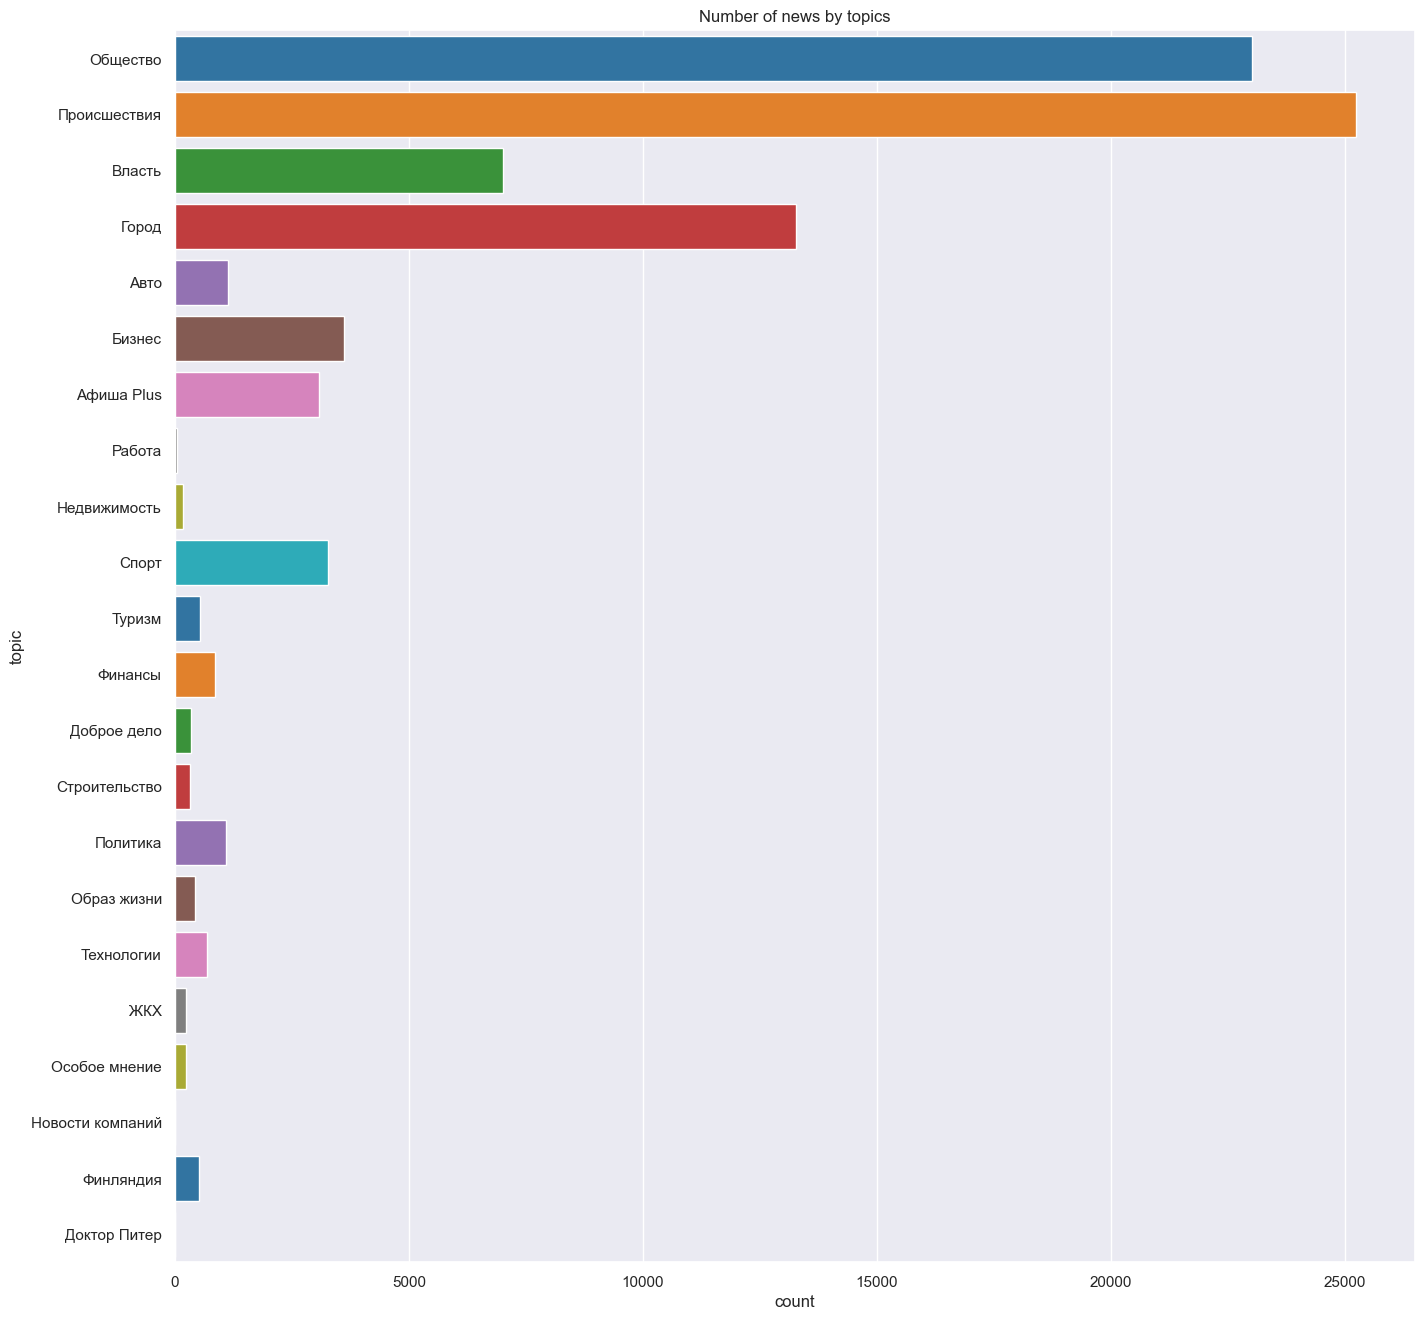

In [130]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(16,16))
sns.countplot(y=data["topic"], hue=data["topic"], palette='tab10', ax=ax, legend=False)
plt.title('Number of news by topics');

We see that our categories are not balanced. If this causes us inconvenience in the future, we can try to combine several categories into one.

Let's combine some classes into one. Based on most news, the following categories can be distinguished:

**Происшествия**
* Происшествия        


**Общество**
* Общество            
* Особое мнение         
* Технологии           


**Город**
* Город               
* Строительство        
* Недвижимость          
* ЖКХ                   
* Авто                 


**Политика**
* Политика             
* Финляндия            
* Власть               
* Открытое письмо         


**Финансы**
* Бизнес               
* Работа                 
* Новости компаний       
* Бизнес-трибуна         
* Финансы              


**Здоровье**
* Доктор Питер         
* Туризм                
* Спорт                


**Образ жизни**
* Образ жизни           
* Афиша Plus           
* Доброе дело           

In [159]:
data['topic'] = data['topic'].replace('Особое мнение', 'Общество')
data['topic'] = data['topic'].replace('Технологии', 'Общество')

data['topic'] = data['topic'].replace('Строительство', 'Город')
data['topic'] = data['topic'].replace('Недвижимость', 'Город')
data['topic'] = data['topic'].replace('ЖКХ', 'Город')
data['topic'] = data['topic'].replace('Авто', 'Город')

data['topic'] = data['topic'].replace('Финляндия', 'Политика')
data['topic'] = data['topic'].replace('Власть', 'Политика')
data['topic'] = data['topic'].replace('Открытое письмо', 'Политика')

data['topic'] = data['topic'].replace('Бизнес', 'Финансы')
data['topic'] = data['topic'].replace('Работа', 'Финансы')
data['topic'] = data['topic'].replace('Новости компаний', 'Финансы')
data['topic'] = data['topic'].replace('Бизнес-трибуна', 'Финансы')

data['topic'] = data['topic'].replace('Доктор Питер', 'Здоровье')
data['topic'] = data['topic'].replace('Туризм', 'Здоровье')
data['topic'] = data['topic'].replace('Спорт', 'Здоровье')

data['topic'] = data['topic'].replace('Афиша Plus', 'Образ жизни')
data['topic'] = data['topic'].replace('Доброе дело', 'Образ жизни')

In [160]:
# Size of each news category
data.topic.value_counts()

Происшествия    25238
Общество        23935
Город           15151
Политика         8621
Финансы          4515
Образ жизни      3867
Здоровье         3817
Name: topic, dtype: int64

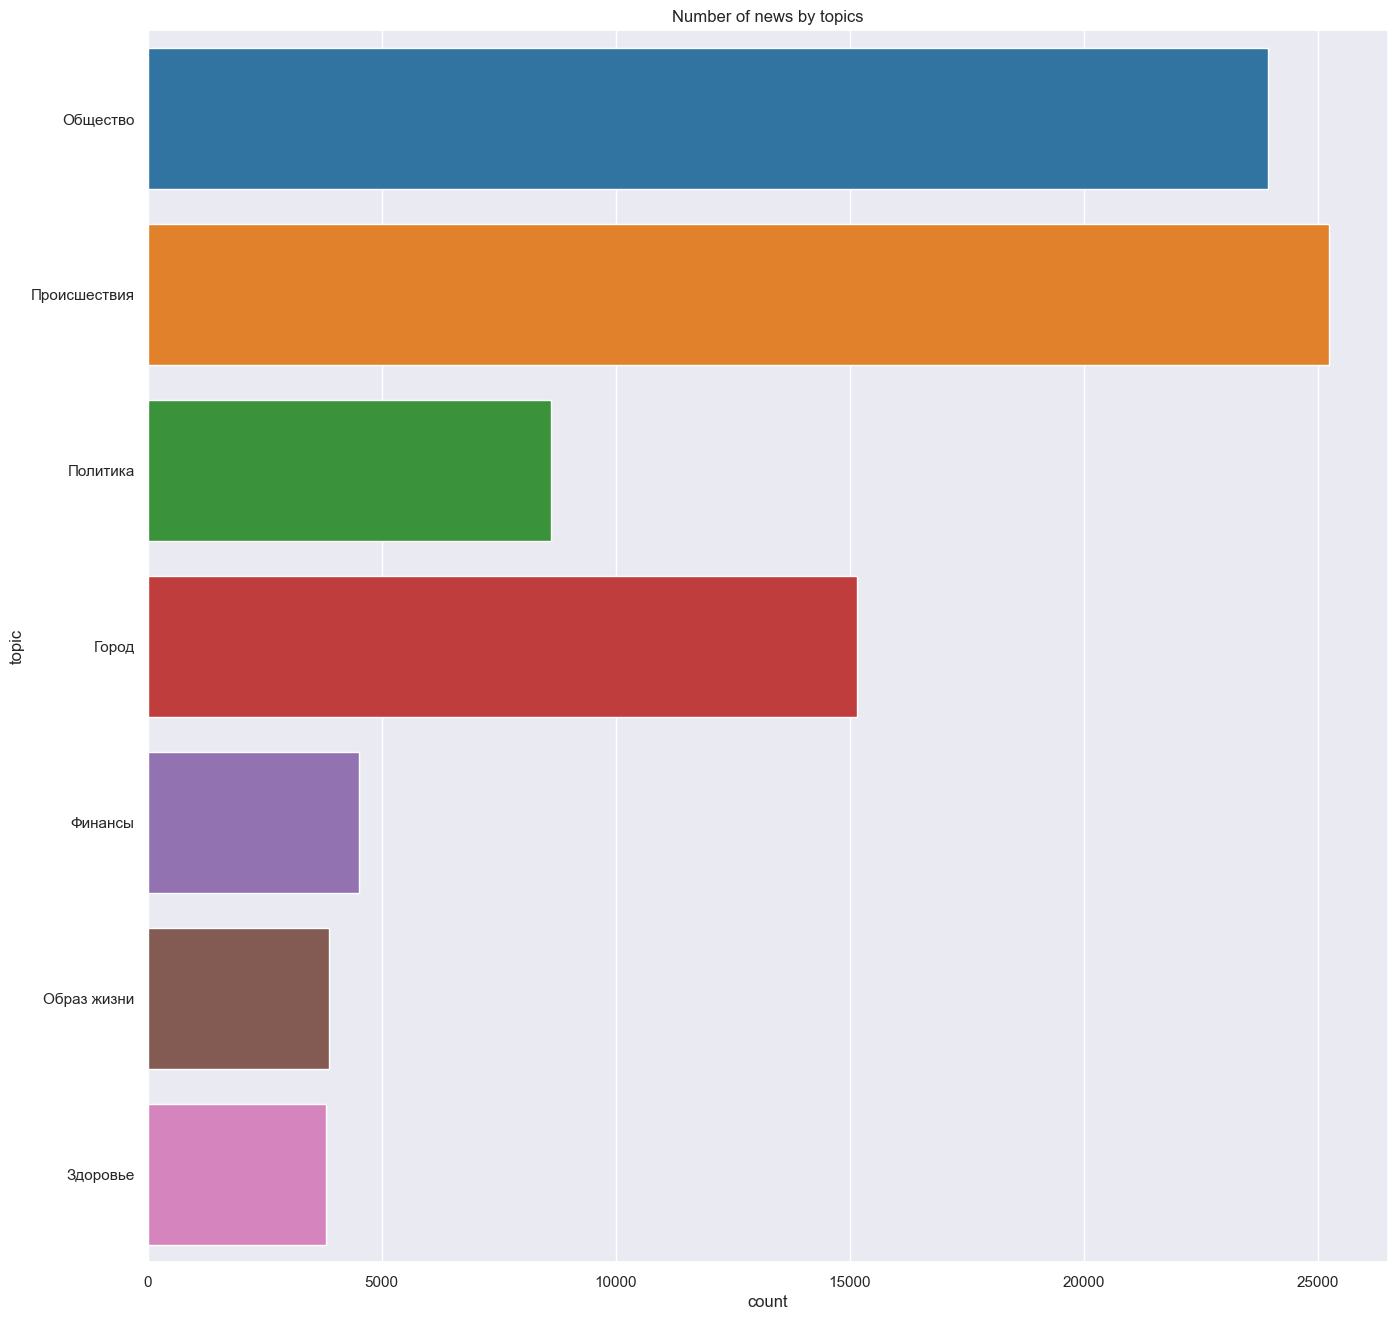

In [161]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(16,16))
sns.countplot(y=data["topic"], hue=data["topic"], palette='tab10', ax=ax, legend=False)
plt.title('Number of news by topics');

Next, we can remove some of the data, leaving 3817 entries in each category. We will get 3817*7 = 26719 records, this will be enough.

Let's start deleting. We will remove lines with gaps in author column.

In [162]:
data[(data['topic'] == 'Происшествия') & (data['author'] == 'Неопознанный')].shape

(21218, 9)

In [163]:
# We need to delete 25238-3817 = 21421 rows
selected_rows = data[(data['topic'] == 'Происшествия') & (data['author'] == 'Неопознанный')]
data = data.drop(selected_rows.index)
selected_rows = data[(data['topic'] == 'Происшествия')].tail(203)
data = data.drop(selected_rows.index)

In [164]:
data[(data['topic'] == 'Общество') & (data['author'] == 'Неопознанный')].shape

(19978, 9)

In [165]:
# We need to delete 23925-3817 = 20108 rows
selected_rows = data[(data['topic'] == 'Общество') & (data['author'] == 'Неопознанный')]
data = data.drop(selected_rows.index)
selected_rows = data[(data['topic'] == 'Общество')].tail(130)
data = data.drop(selected_rows.index)

In [166]:
data[(data['topic'] == 'Город') & (data['author'] == 'Неопознанный')].shape

(13109, 9)

In [167]:
# We need to delete 15151-3817 = 11334 rows
selected_rows = data[(data['topic'] == 'Город') & (data['author'] == 'Неопознанный')].tail(11334)
data = data.drop(selected_rows.index)

In [169]:
data[(data['topic'] == 'Политика') & (data['author'] == 'Неопознанный')].shape

(7617, 9)

In [170]:
# We need to delete 8621-3817 = 4804 rows
selected_rows = data[(data['topic'] == 'Политика') & (data['author'] == 'Неопознанный')].tail(4804)
data = data.drop(selected_rows.index)

In [172]:
data[(data['topic'] == 'Финансы') & (data['author'] == 'Неопознанный')].shape

(3973, 9)

In [173]:
# We need to delete 4515-3817 = 698 rows
selected_rows = data[(data['topic'] == 'Финансы') & (data['author'] == 'Неопознанный')].tail(698)
data = data.drop(selected_rows.index)

In [175]:
data[(data['topic'] == 'Образ жизни') & (data['author'] == 'Неопознанный')].shape

(3017, 9)

In [176]:
# We need to delete 3867-3817 = 50 rows
selected_rows = data[(data['topic'] == 'Образ жизни') & (data['author'] == 'Неопознанный')].tail(50)
data = data.drop(selected_rows.index)

In [179]:
selected_rows = data[(data['topic'] == 'Общество')].tail(10)
data = data.drop(selected_rows.index)

In [180]:
# Size of each news category
data.topic.value_counts()

Общество        3817
Происшествия    3817
Политика        3817
Город           3817
Финансы         3817
Образ жизни     3817
Здоровье        3817
Name: topic, dtype: int64

Let's see what we got

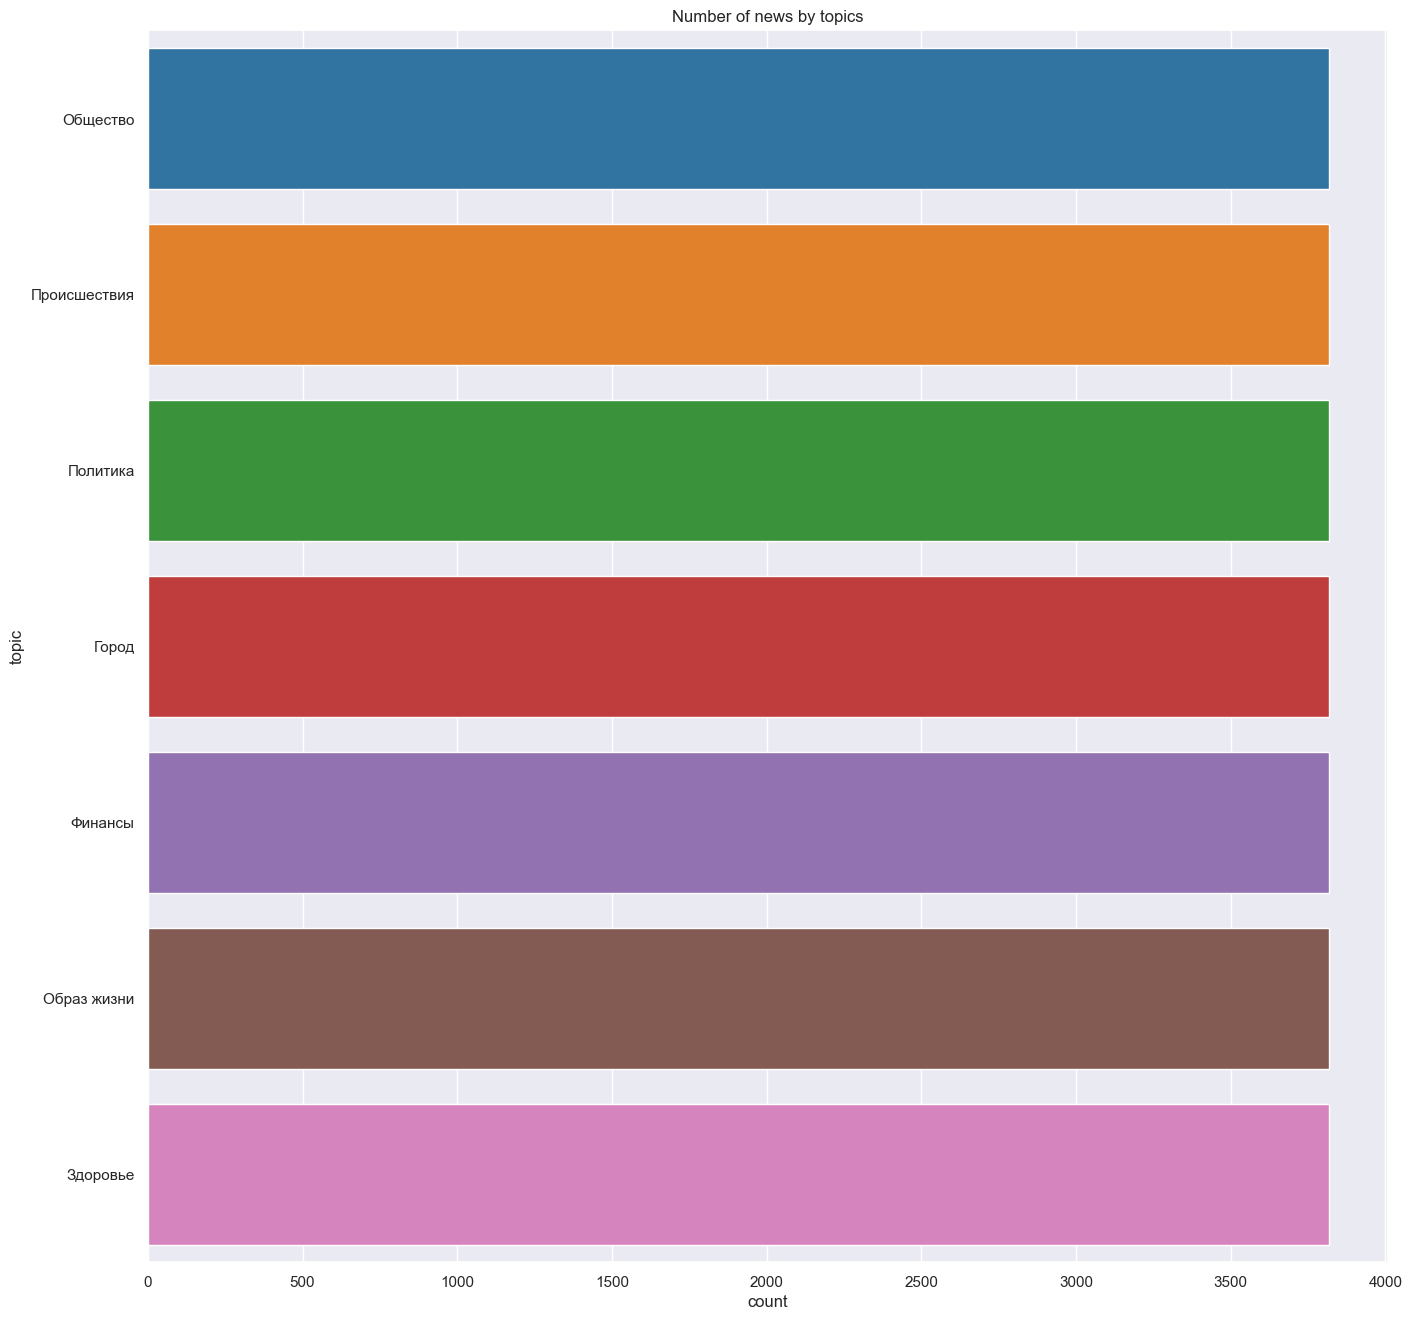

In [181]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(16,16))
sns.countplot(y=data["topic"], hue=data["topic"], palette='tab10', ax=ax, legend=False)
plt.title('Number of news by topics');

Let's add features to our dataset - `year`, `month`, `weekday`. This can play an important role for the model

In [186]:
data.head()

date                                              title  \
0  2023-10-20  «Интифада будет». Медведев высказался о послед...   
1  2023-10-20  Тело погибшей в горах Непала российской альпин...   
2  2023-10-20  Семиклассник в Колпино рассказал, как избежал ...   
3  2023-10-20  Путин собрал Совет безопасности. Речь шла об о...   
4  2023-10-20  BMW и рейсовый автобус не разъехались в Колпин...   

          topic                                           url      time  \
0      Общество  https://www.fontanka.ru/2023/10/20/72830546/  12:34:00   
1  Происшествия  https://www.fontanka.ru/2023/10/20/72830387/  12:24:00   
2  Происшествия  https://www.fontanka.ru/2023/10/20/72830339/  12:21:00   
3      Политика  https://www.fontanka.ru/2023/10/20/72830516/  12:15:00   
4  Происшествия  https://www.fontanka.ru/2023/10/20/72830249/  12:12:00   

   comm_num              author  views  \
0        12      Елена Манькова   1082   
1         8       Кузьмин Артем   2427   
2         4  Константин Митягин   1351   
3        46     Вячеслав Пашкин   2119   
4         3  Виктория Трофимова    572   

                                             content  
0  Зампред Совбеза РФ Дмитрий Медведев высказался...  
1  Тело российской альпинистки Надежды Оленевой, ...  
2  Жительница Колпино обратилась в полицию после ...  
3  Президент РФ Владимир Путин в режиме видеоконф...  
4  Автобус с пассажирами попал в ДТП в Колпинском...

In [187]:
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.strftime("%B")
data['weekday'] = data['date'].dt.strftime('%A')

What findings can be drawn from the plots below:

- Most of the news is for 2023, it keeps the theme that we have removed the classes in the cells above from the tail of the dataset
- Fewer news items relate to 2018, a little more – to 2019 and 2020.
- Most news comes from the early autumn; we can say that in winter there is less news.
- The least news is on weekends, but on subsequent days the amount of news is balanced.

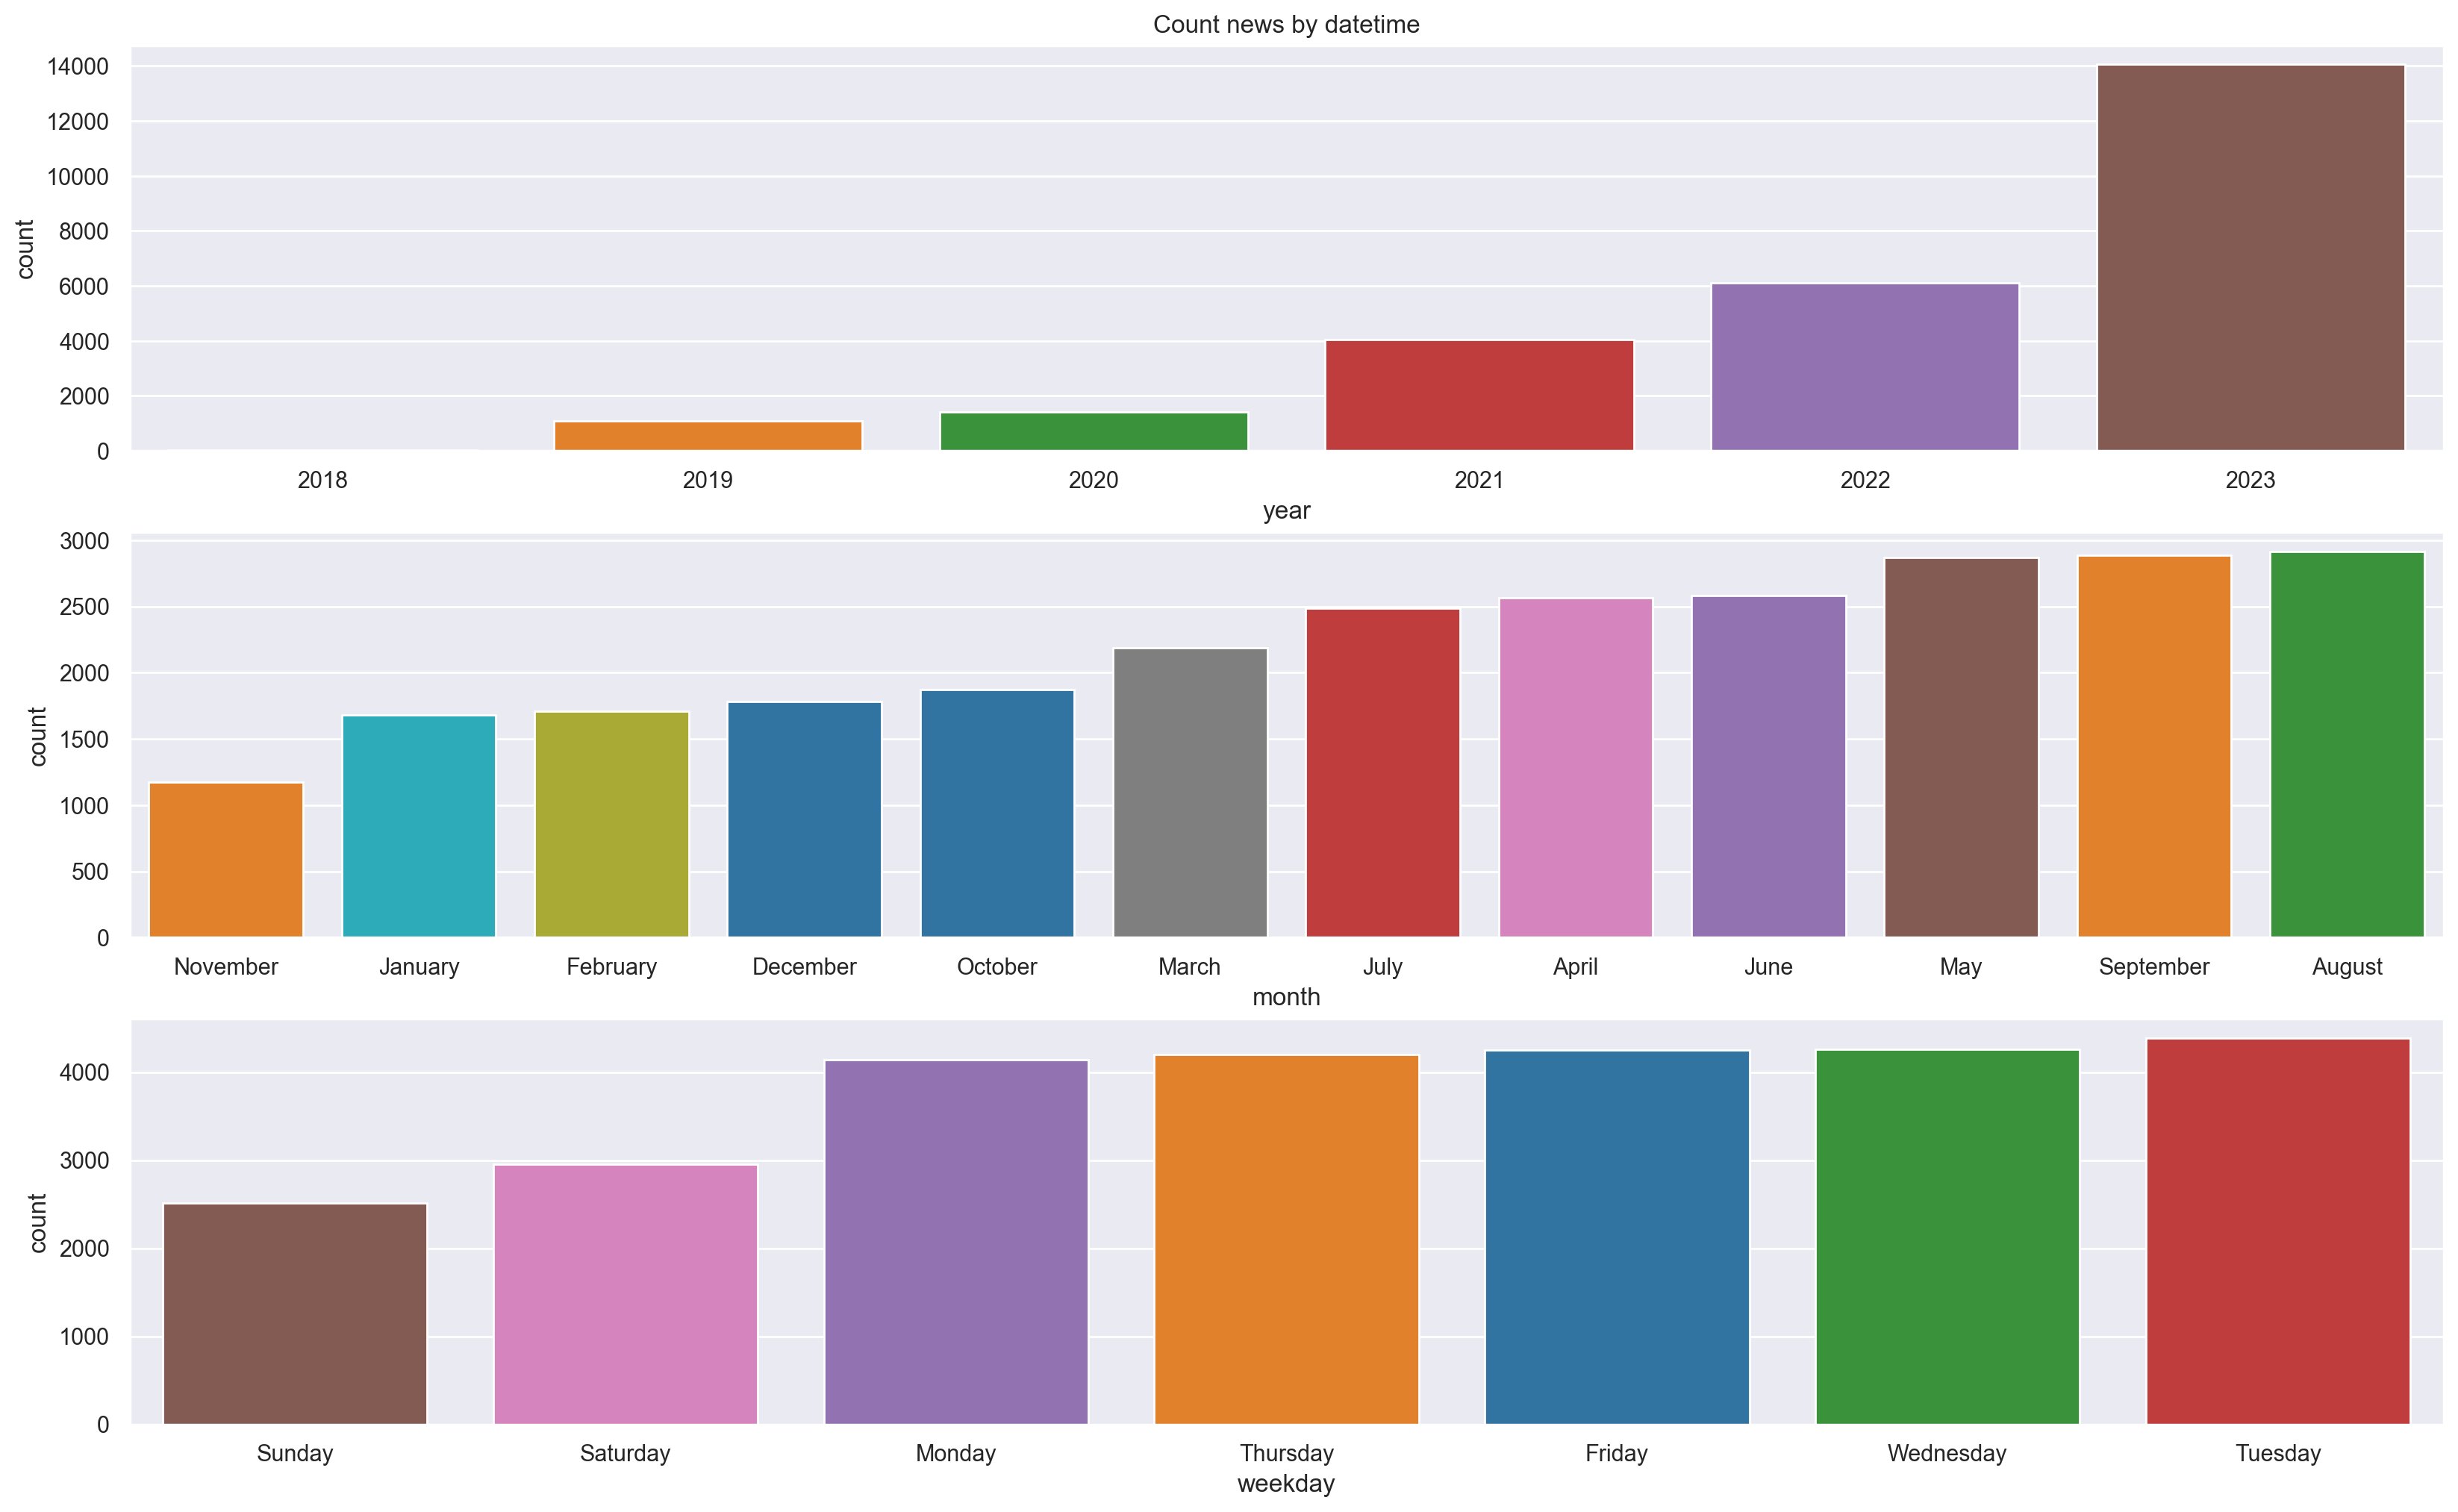

In [188]:
fig, axs = plt.subplots(3, 1, figsize=(20, 12), dpi=200)
for ind, col in enumerate(['year', 'month', 'weekday']):
    sns.countplot(x=data[col], hue=data[col], palette='tab10', ax=axs[ind], order=data[col].value_counts(ascending=True).index, legend=False)
axs[0].set_title('Count news by datetime');

Let's look at the distribution of the number of views for each topic. We see that there are very heavy tails in each of the topics, that is, the dataset contains articles that stand out strongly in their popularity.

However, it should immediately be noted that the number of views also depends on the age of the article, so the dependence of popularity on the number of views has not a linear, but a more complex relationship.

You can also notice anomalous outliers in the topics “Политика” and “Здоровье”.

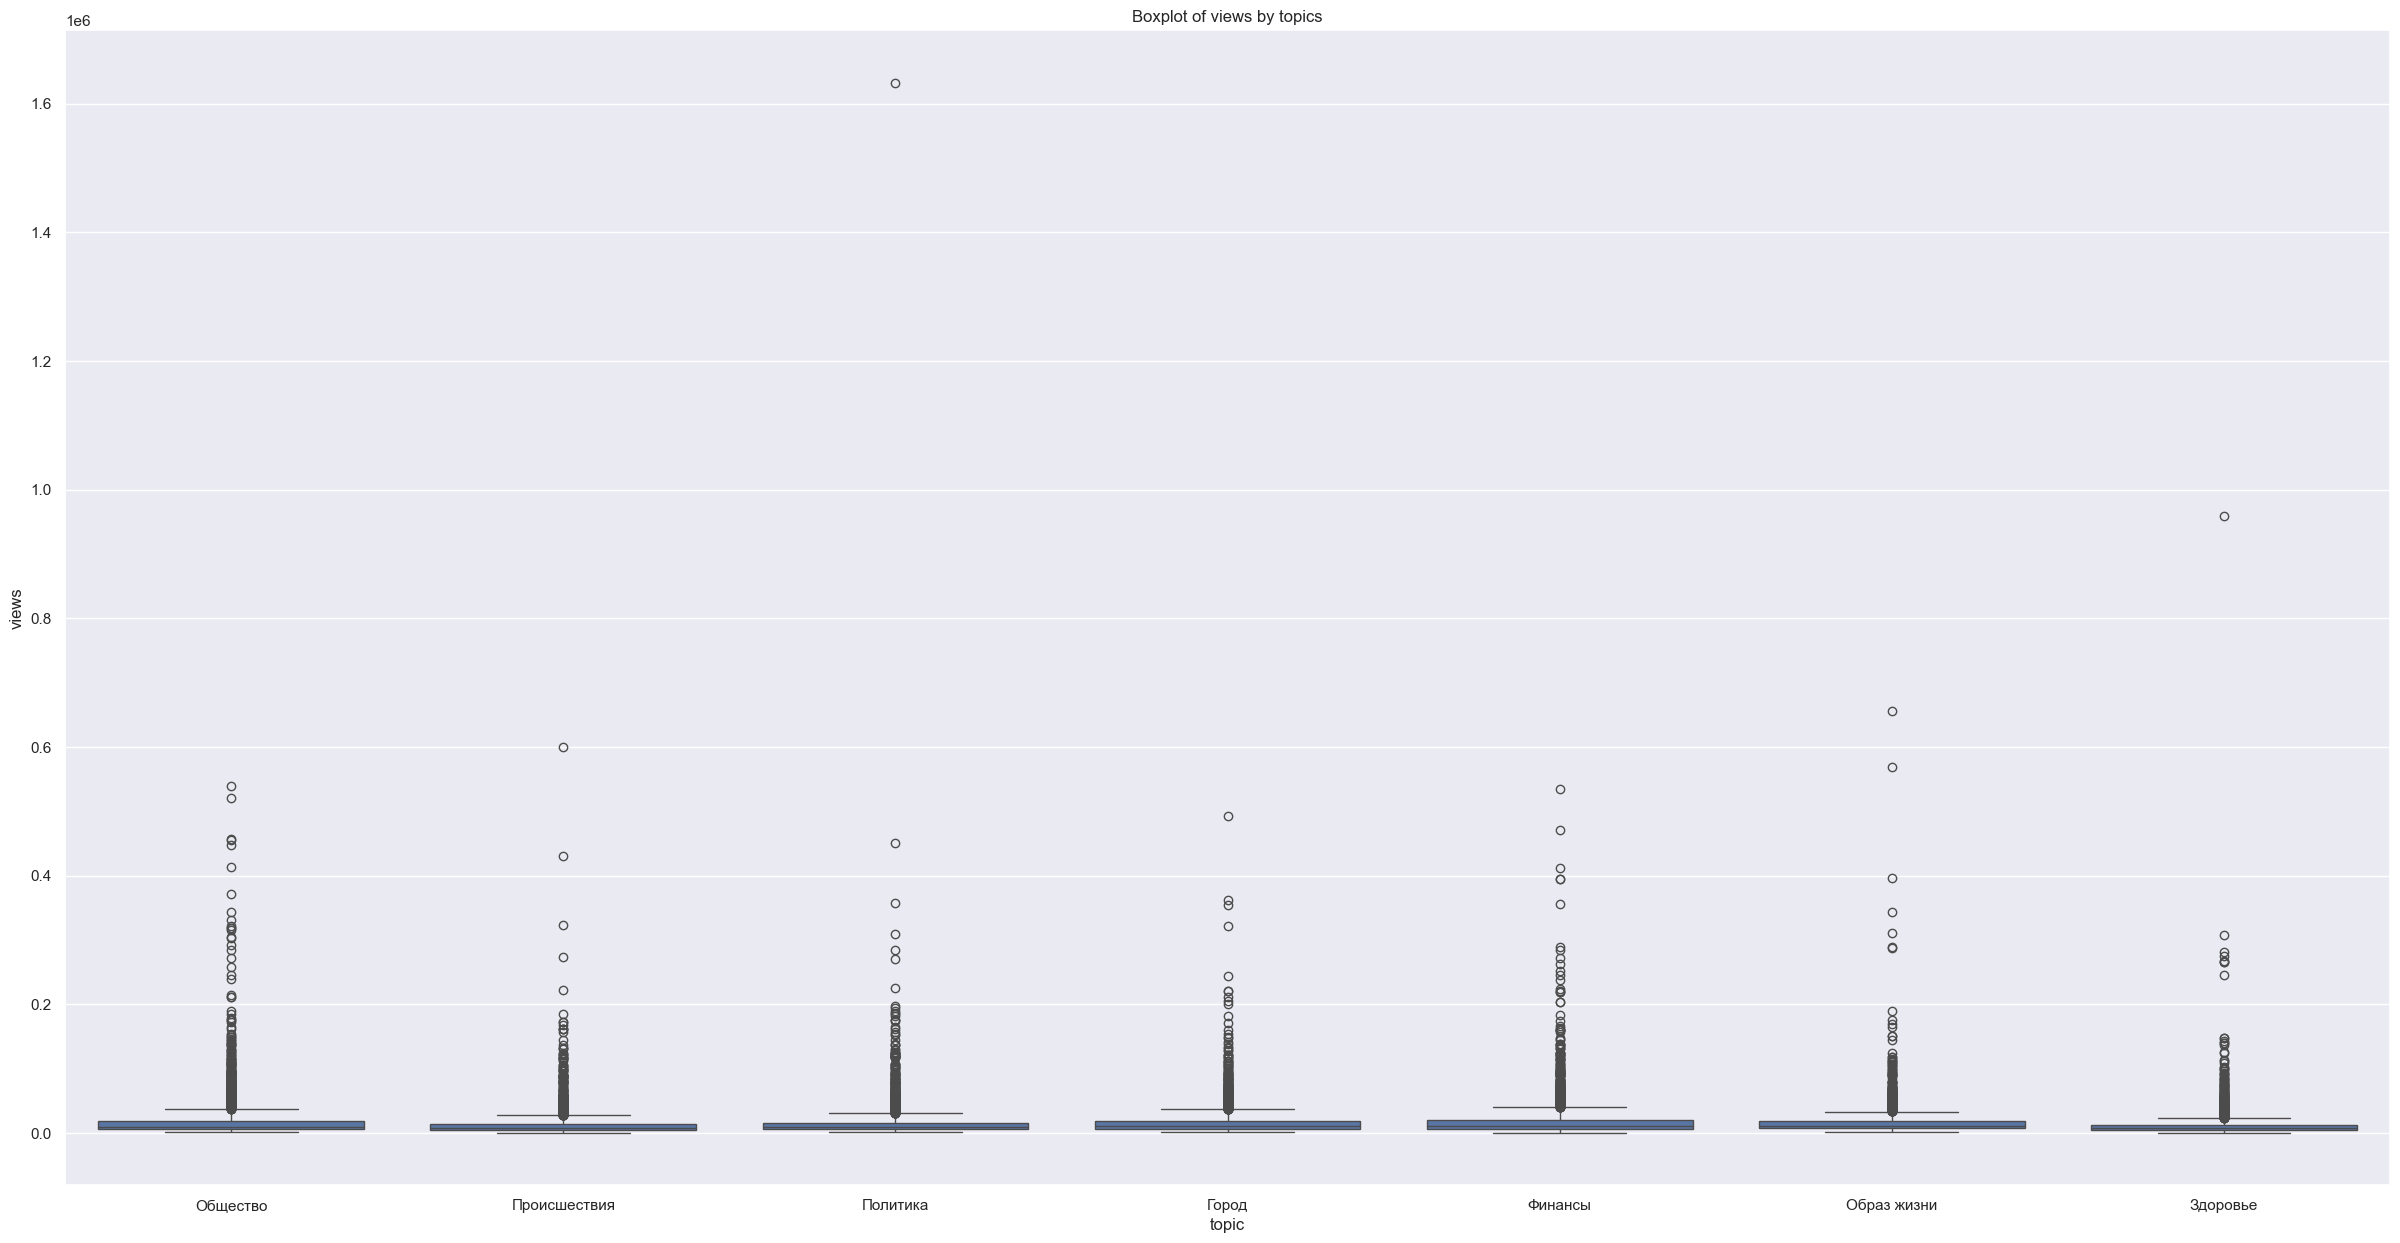

In [189]:
fig, ax = plt.subplots(1, 1, figsize=(30, 15), dpi=100)
sns.boxplot(x="topic", y="views", data=data, ax=ax)
plt.title('Boxplot of views by topics');

Let's look at the overall distribution of the number of views over topic across all data.

C:\Users\mivan\AppData\Local\Temp\ipykernel_13528\1364922983.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(


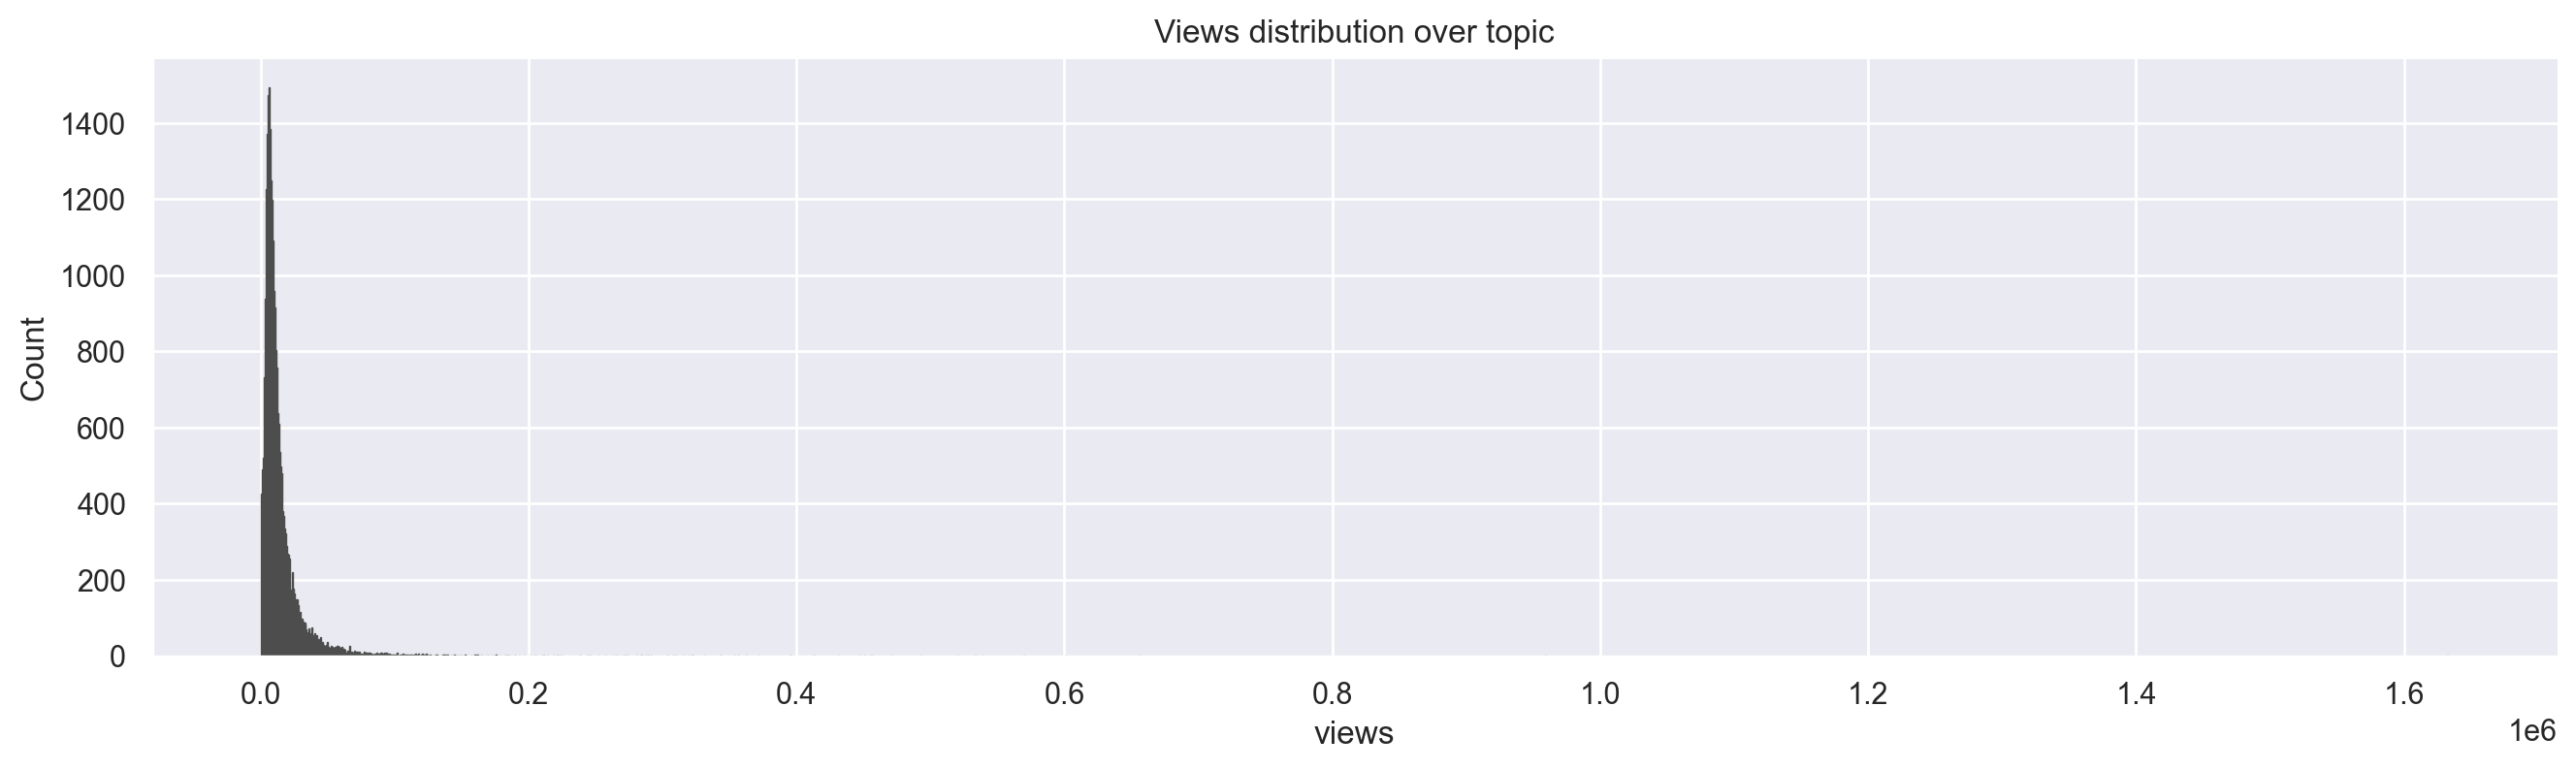

In [190]:
fig, axs = plt.subplots(1, 1, figsize=(16, 4), dpi=200)
sns.despine(fig)

sns.histplot(
    data,
    x="views",
    edgecolor=".3",
    palette="coolwarm",
    linewidth=.5,
);
axs.set_title('Views distribution over topic');

First, as already noted, the distribution of the number of views has distant outliers. Moreover, the shape of the distribution is very similar to the lognormal distribution. Therefore, we will add one more feature - the logarithm of the number of views, shifted by one, since the number of views can take the value zero.

On the plot below, the x-axis shows log1p of the number of views, and the y-axis shows the number of articles on different topics that have that number of views. It can be seen that the distribution now has a shape close to the normal distribution, if you pay attention to the most popular topics.

In [191]:
data['log_views'] = np.log1p(data['views'])

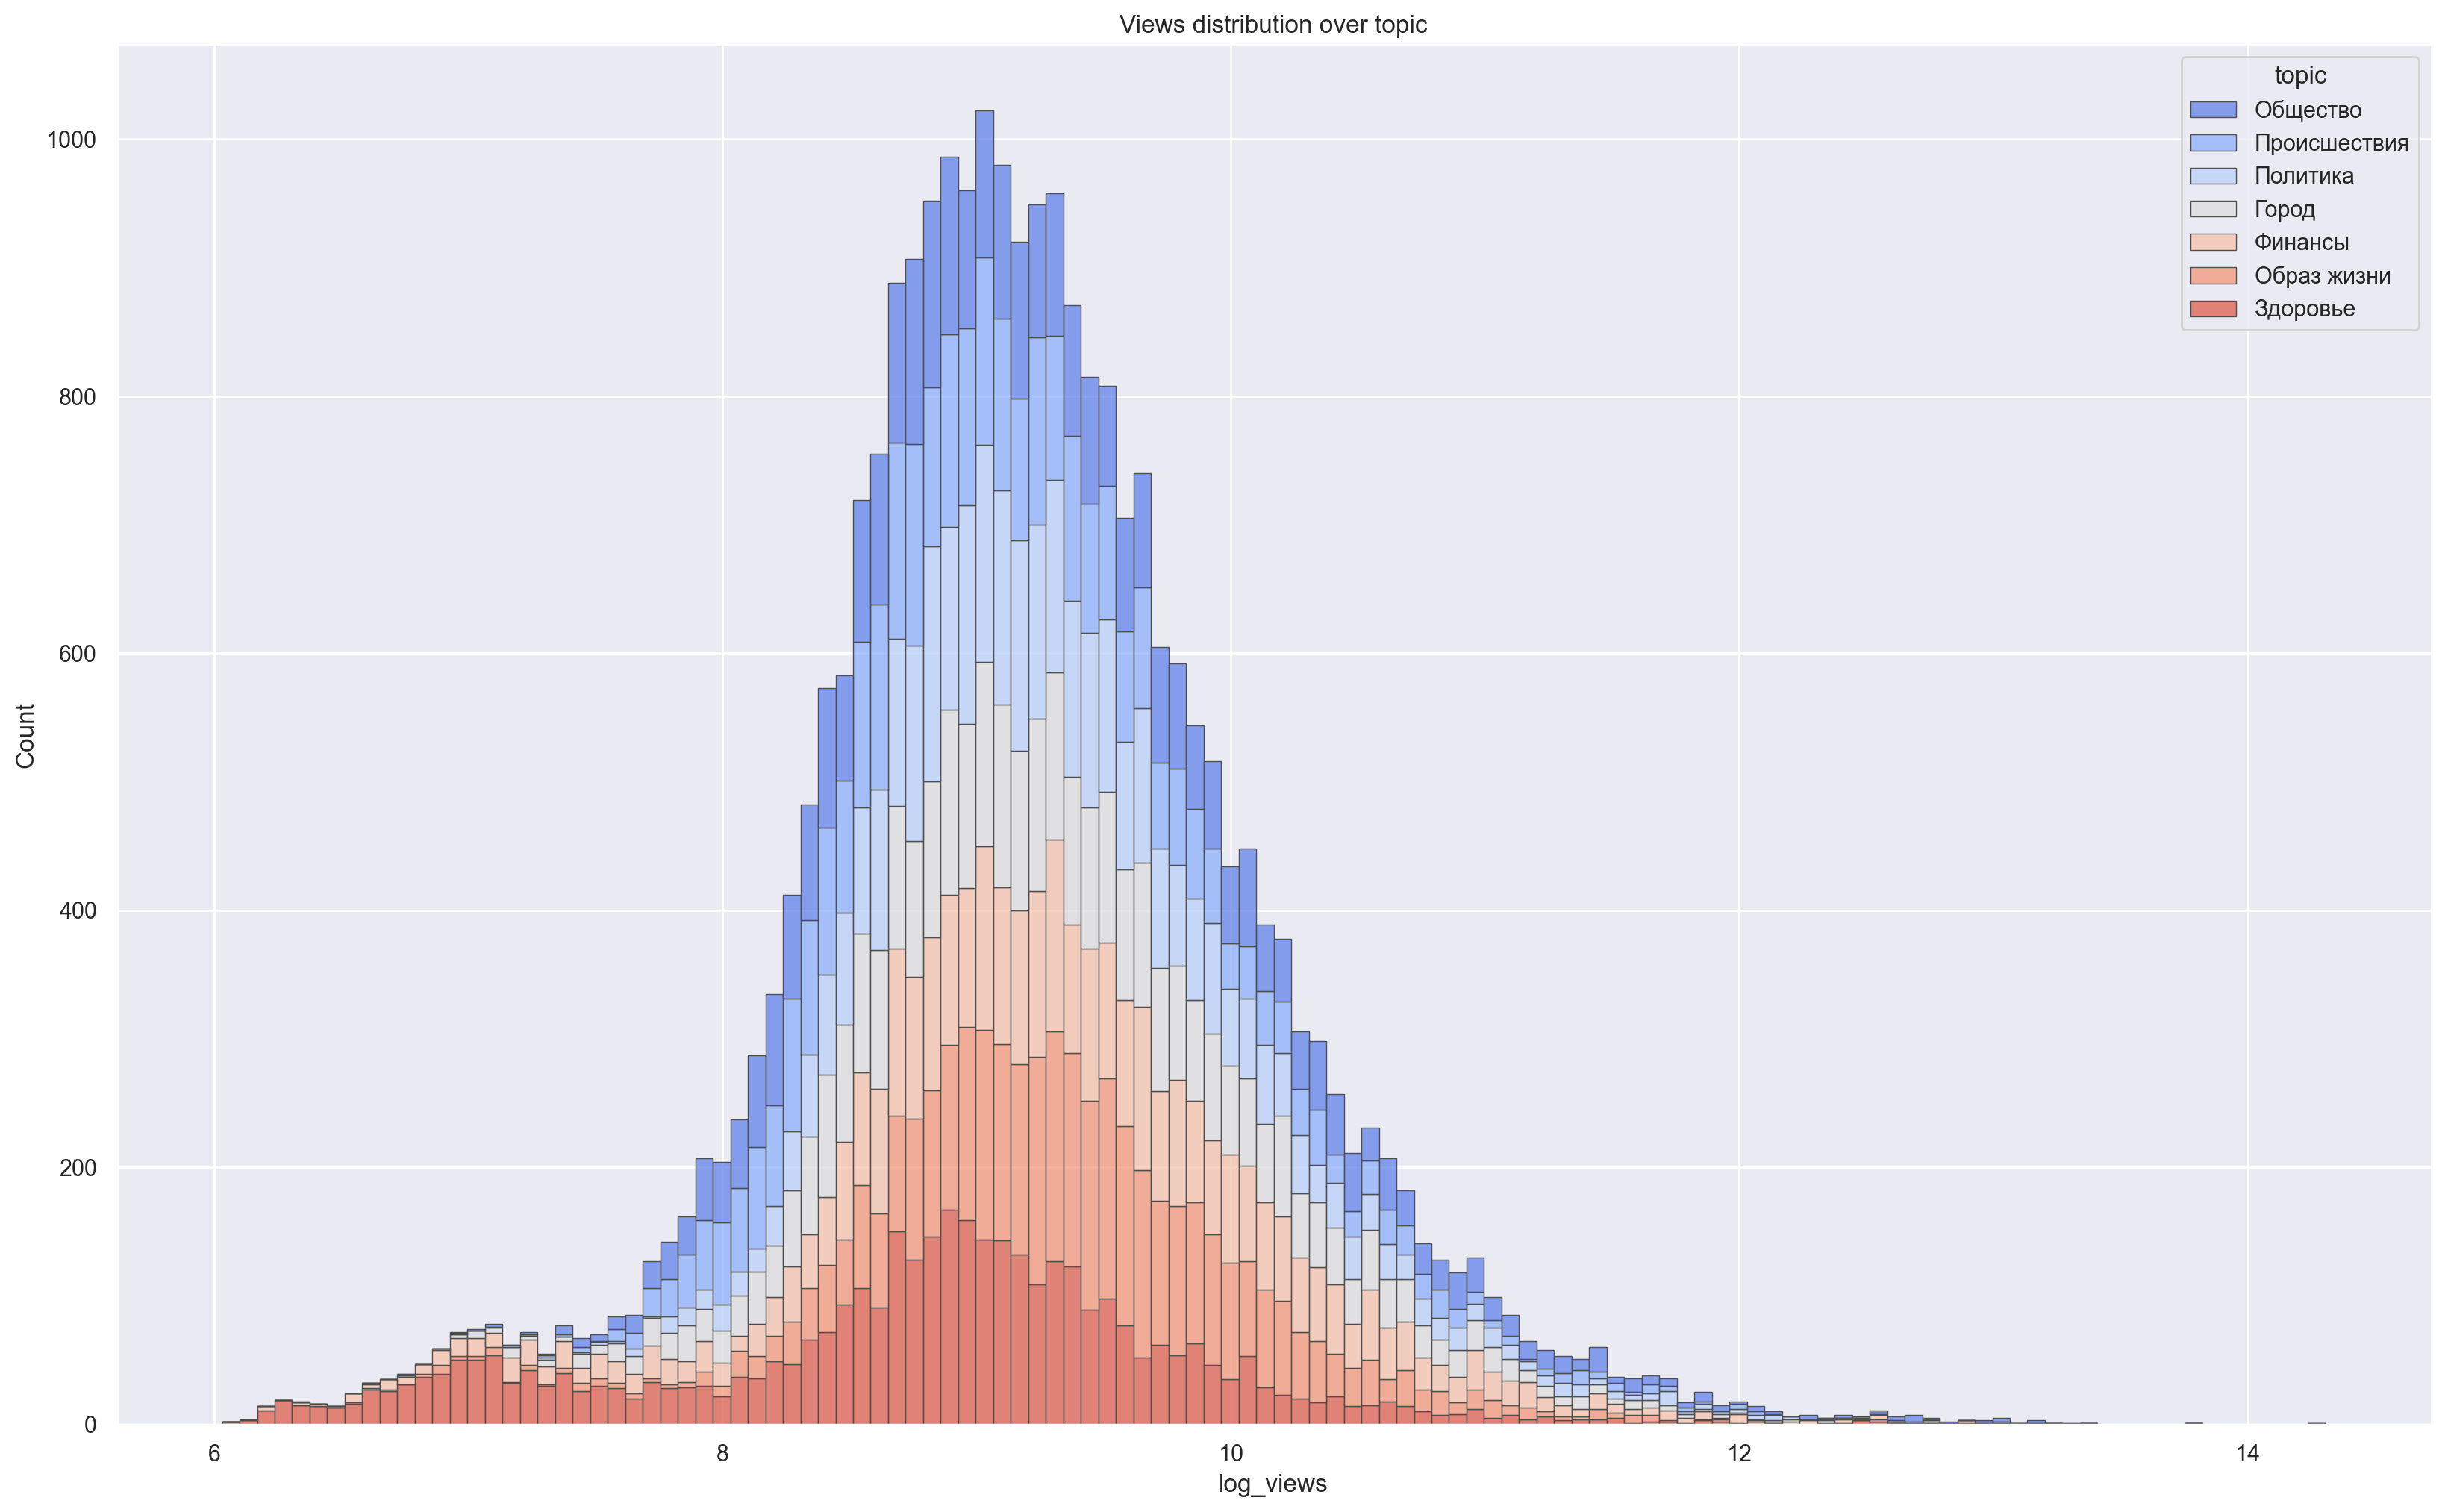

In [192]:
fig, axs = plt.subplots(1, 1, figsize=(20, 12), dpi=200)
sns.despine(fig)

sns.histplot(
    data,
    x="log_views",
    hue="topic",
    multiple="stack",
    edgecolor=".3",
    palette="coolwarm",
    linewidth=.5,
);
axs.set_title('Views distribution over topic');

Let's use the Mann-Whitney test to check how close the distribution of views is to lognormal.

In [193]:
# Generate a sample from a normal distribution with the same mat. expectation and variance, like our variable
x = np.random.normal(loc=data['log_views'].mean(), scale=data['log_views'].std(), size=100000)

# The Mann-Whitney test and p-significance
U1, p = mannwhitneyu(x, data['log_views'])

print('P-significance:', p)

# Decision limit is 1%
if p < 0.01:
    print('The distribution of the number of views can be considered lognormal')
else:
    print('The distribution of the number of views cant be considered lognormal')

P-significance: 0.01427632370886753
The distribution of the number of views cant be considered lognormal


We see that distribution of the number of views is not lognormal

Let's calculate the length of the title and body text.

In [194]:
data['len_title'] = data['title'].str.len()
data['len_content'] = data['content'].str.len()

Let's see how they look in the context of each category.

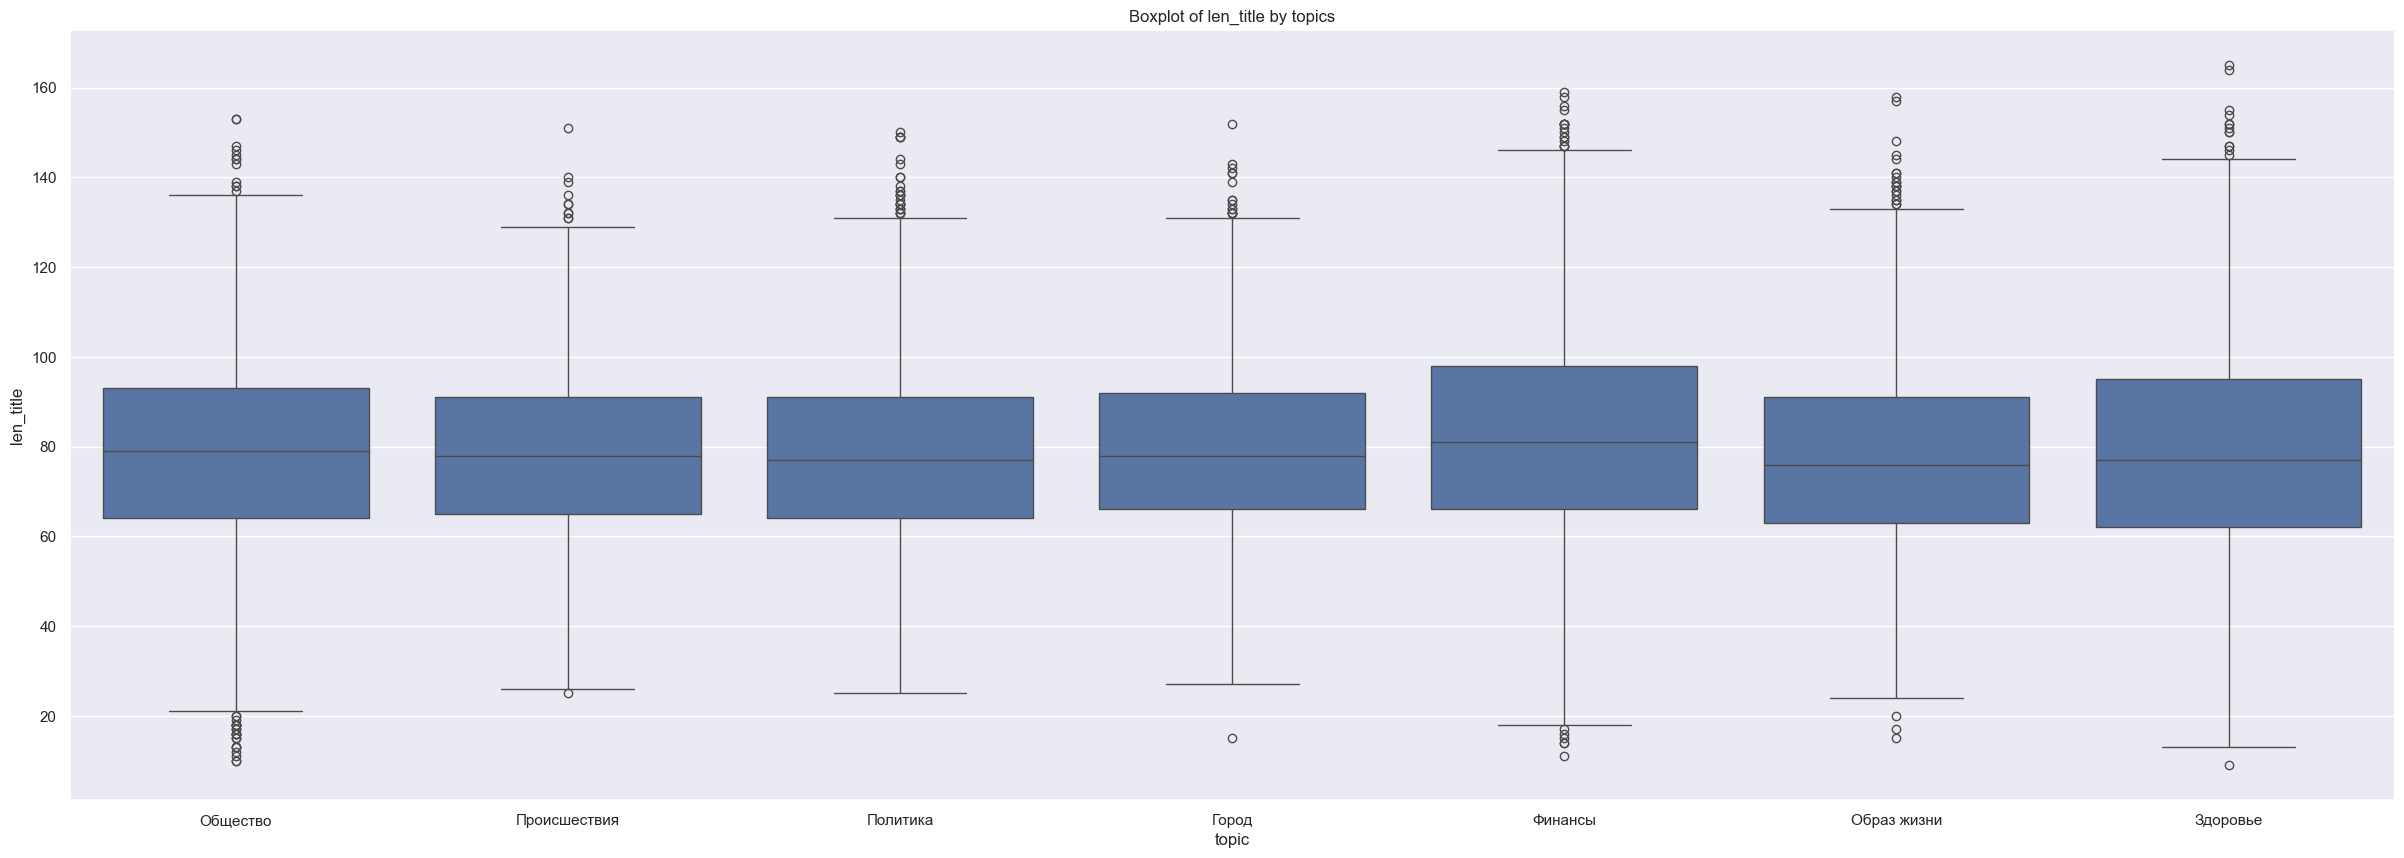

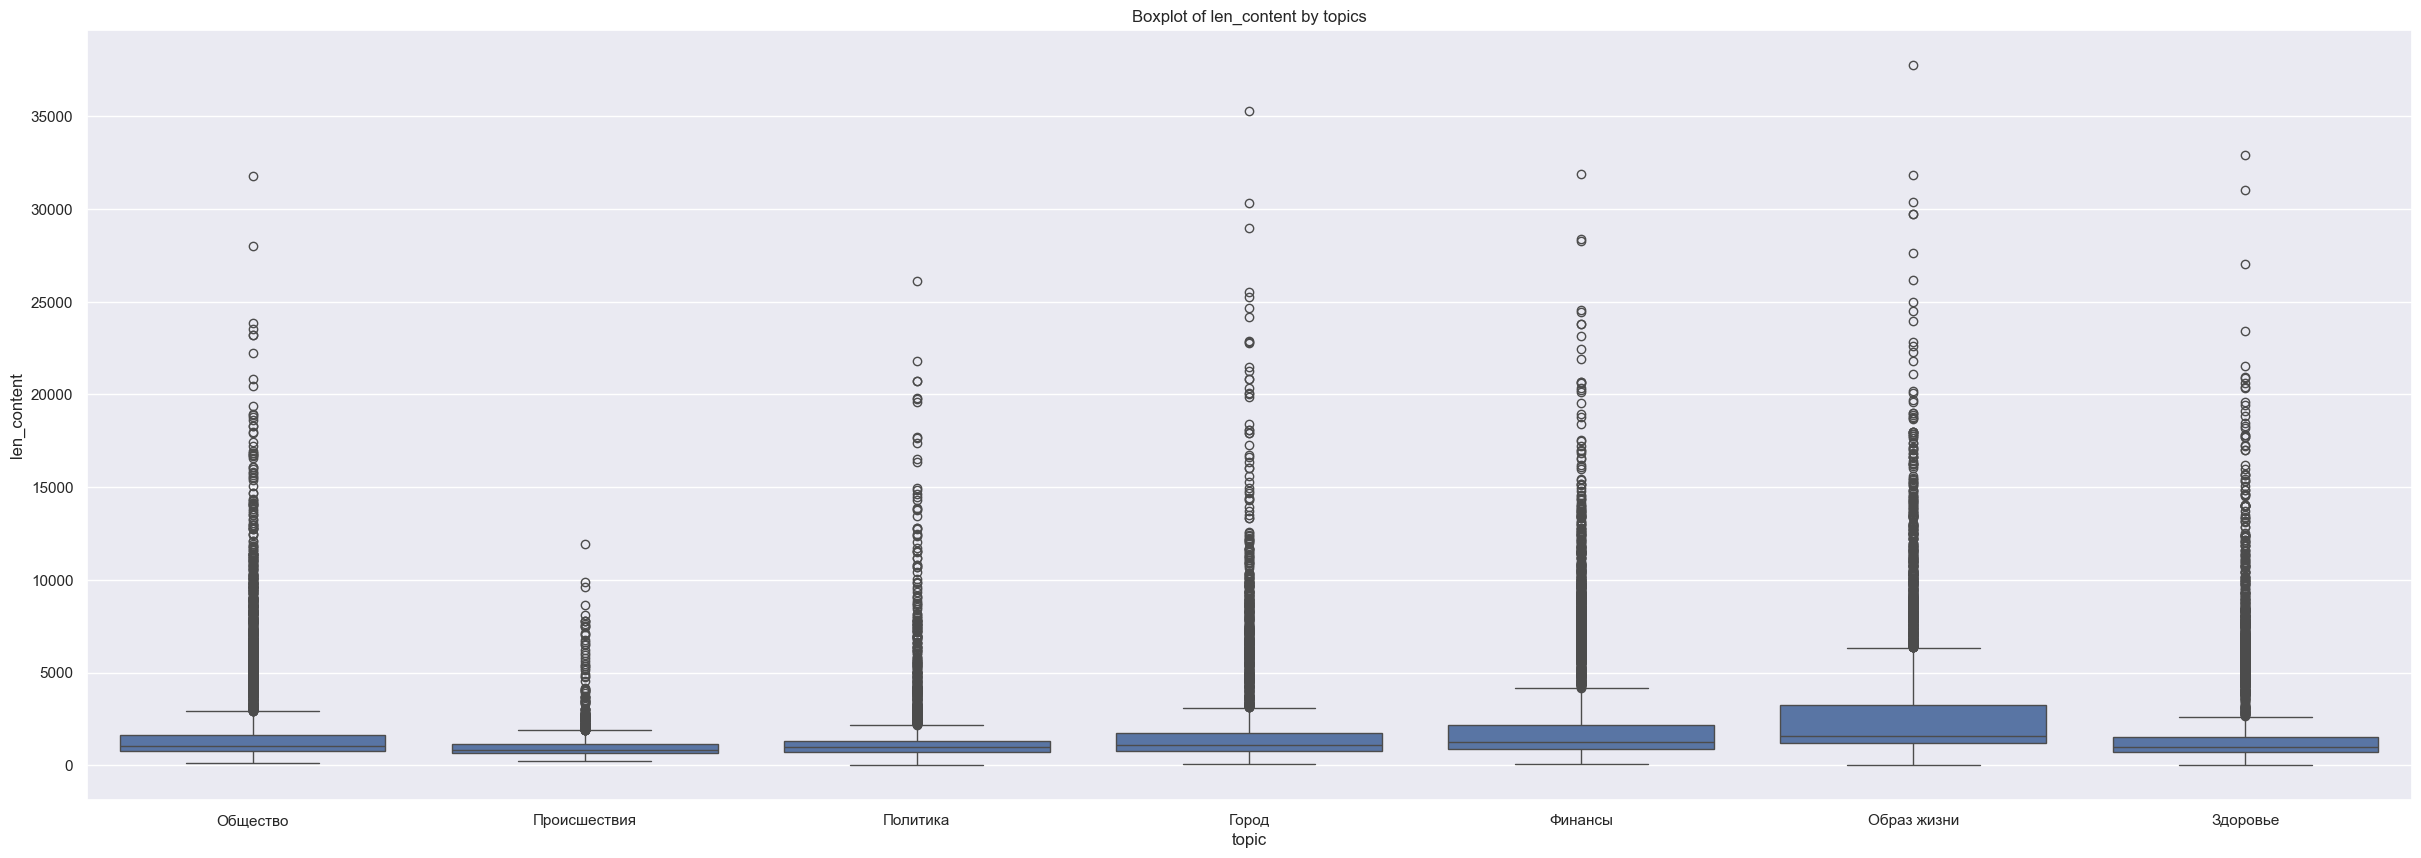

In [195]:
for col in ['len_title', 'len_content']:
    fig, ax = plt.subplots(1, 1, figsize=(30, 10), dpi=100)
    sns.boxplot(x="topic", y=col, data=data, ax=ax)
    plt.title(f'Boxplot of {col} by topics');

What we can notice:
- The average title length for all categories is about 78-82 characters, however in some categories this is not the case
- The length of the text has heavy tails. This applies to all topics, but more in "Образ жизни" topic

Let's look at the average comment number

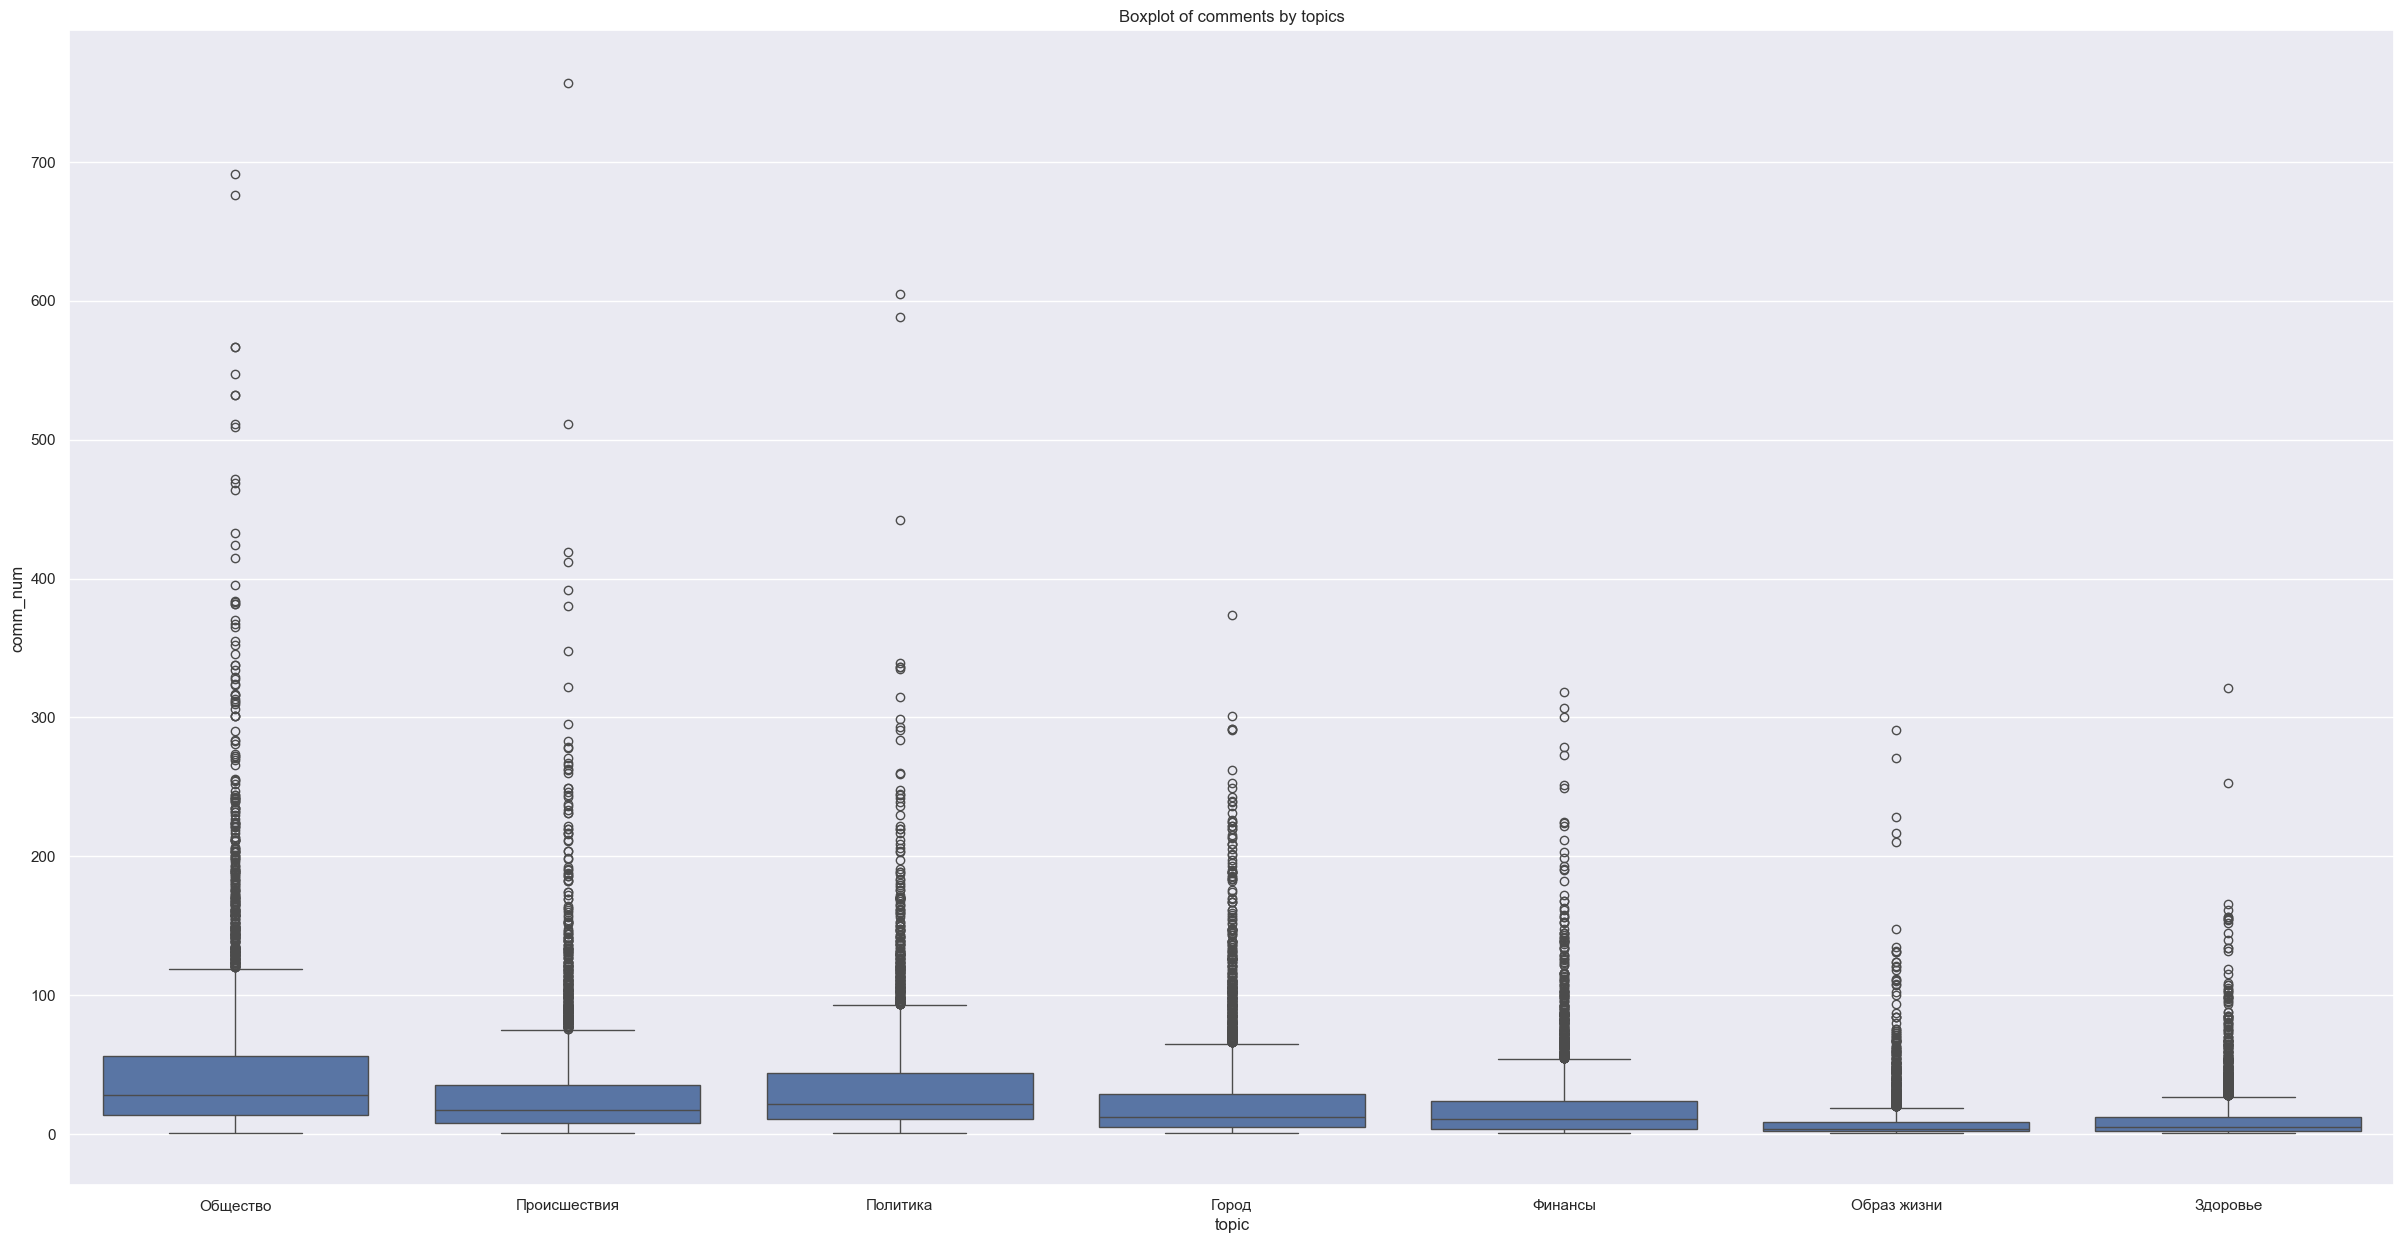

In [201]:
fig, ax = plt.subplots(1, 1, figsize=(30, 15), dpi=100)
sns.boxplot(x="topic", y="comm_num", data=data, ax=ax)
plt.title('Boxplot of comments by topics');

What we can notice:
- The average comment's quantity for all categories is about 20 characters, however in some categories this is not the case
- The number of comments has heavy tails. This applies to all topics, but more in "Происшествия" topic

C:\Users\mivan\AppData\Local\Temp\ipykernel_13528\2564764457.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(


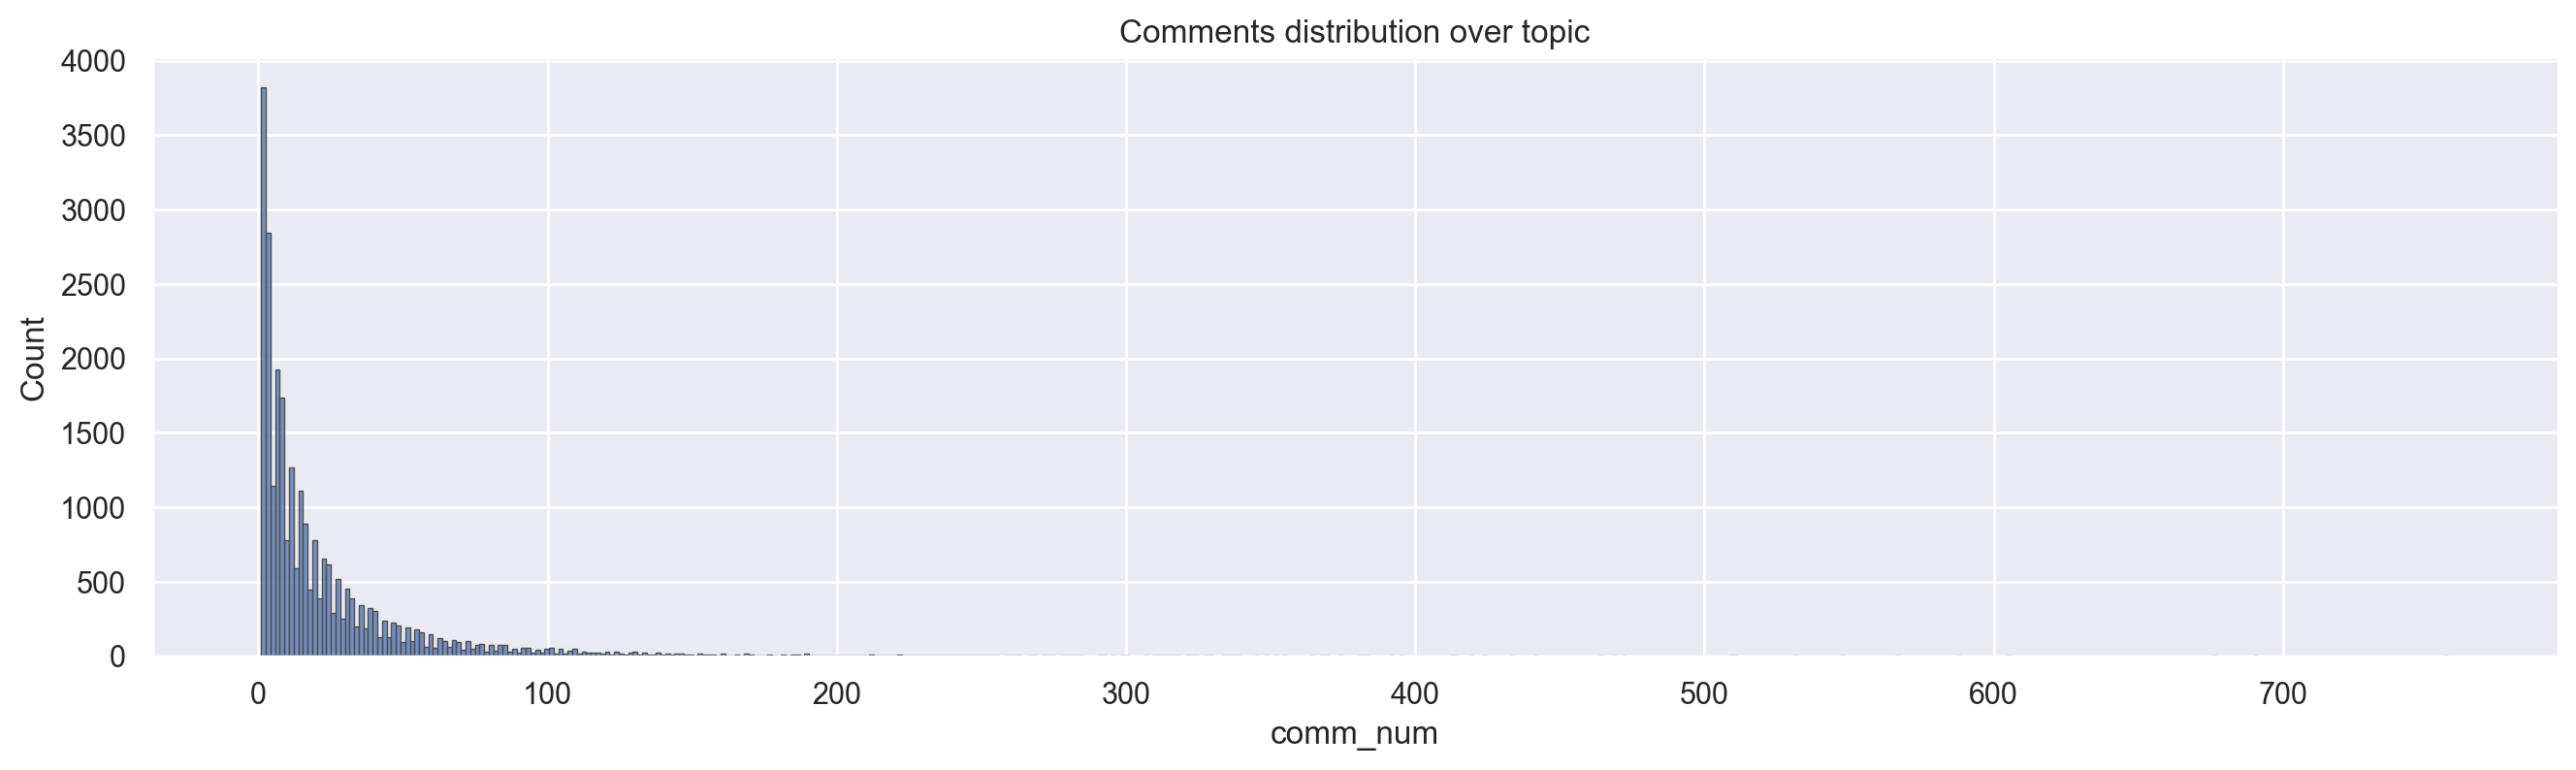

In [196]:
fig, axs = plt.subplots(1, 1, figsize=(16, 4), dpi=200)
sns.despine(fig)

sns.histplot(
    data,
    x="comm_num",
    edgecolor=".3",
    palette="coolwarm",
    linewidth=.5,
);
axs.set_title('Comments distribution over topic');

The distribution of comments looks like a lognormal distribution

Let's look at the distribution of the logarithm of comments and test it using the Mann-Whitney test

In [197]:
data['log_comm'] = np.log1p(data['comm_num'])

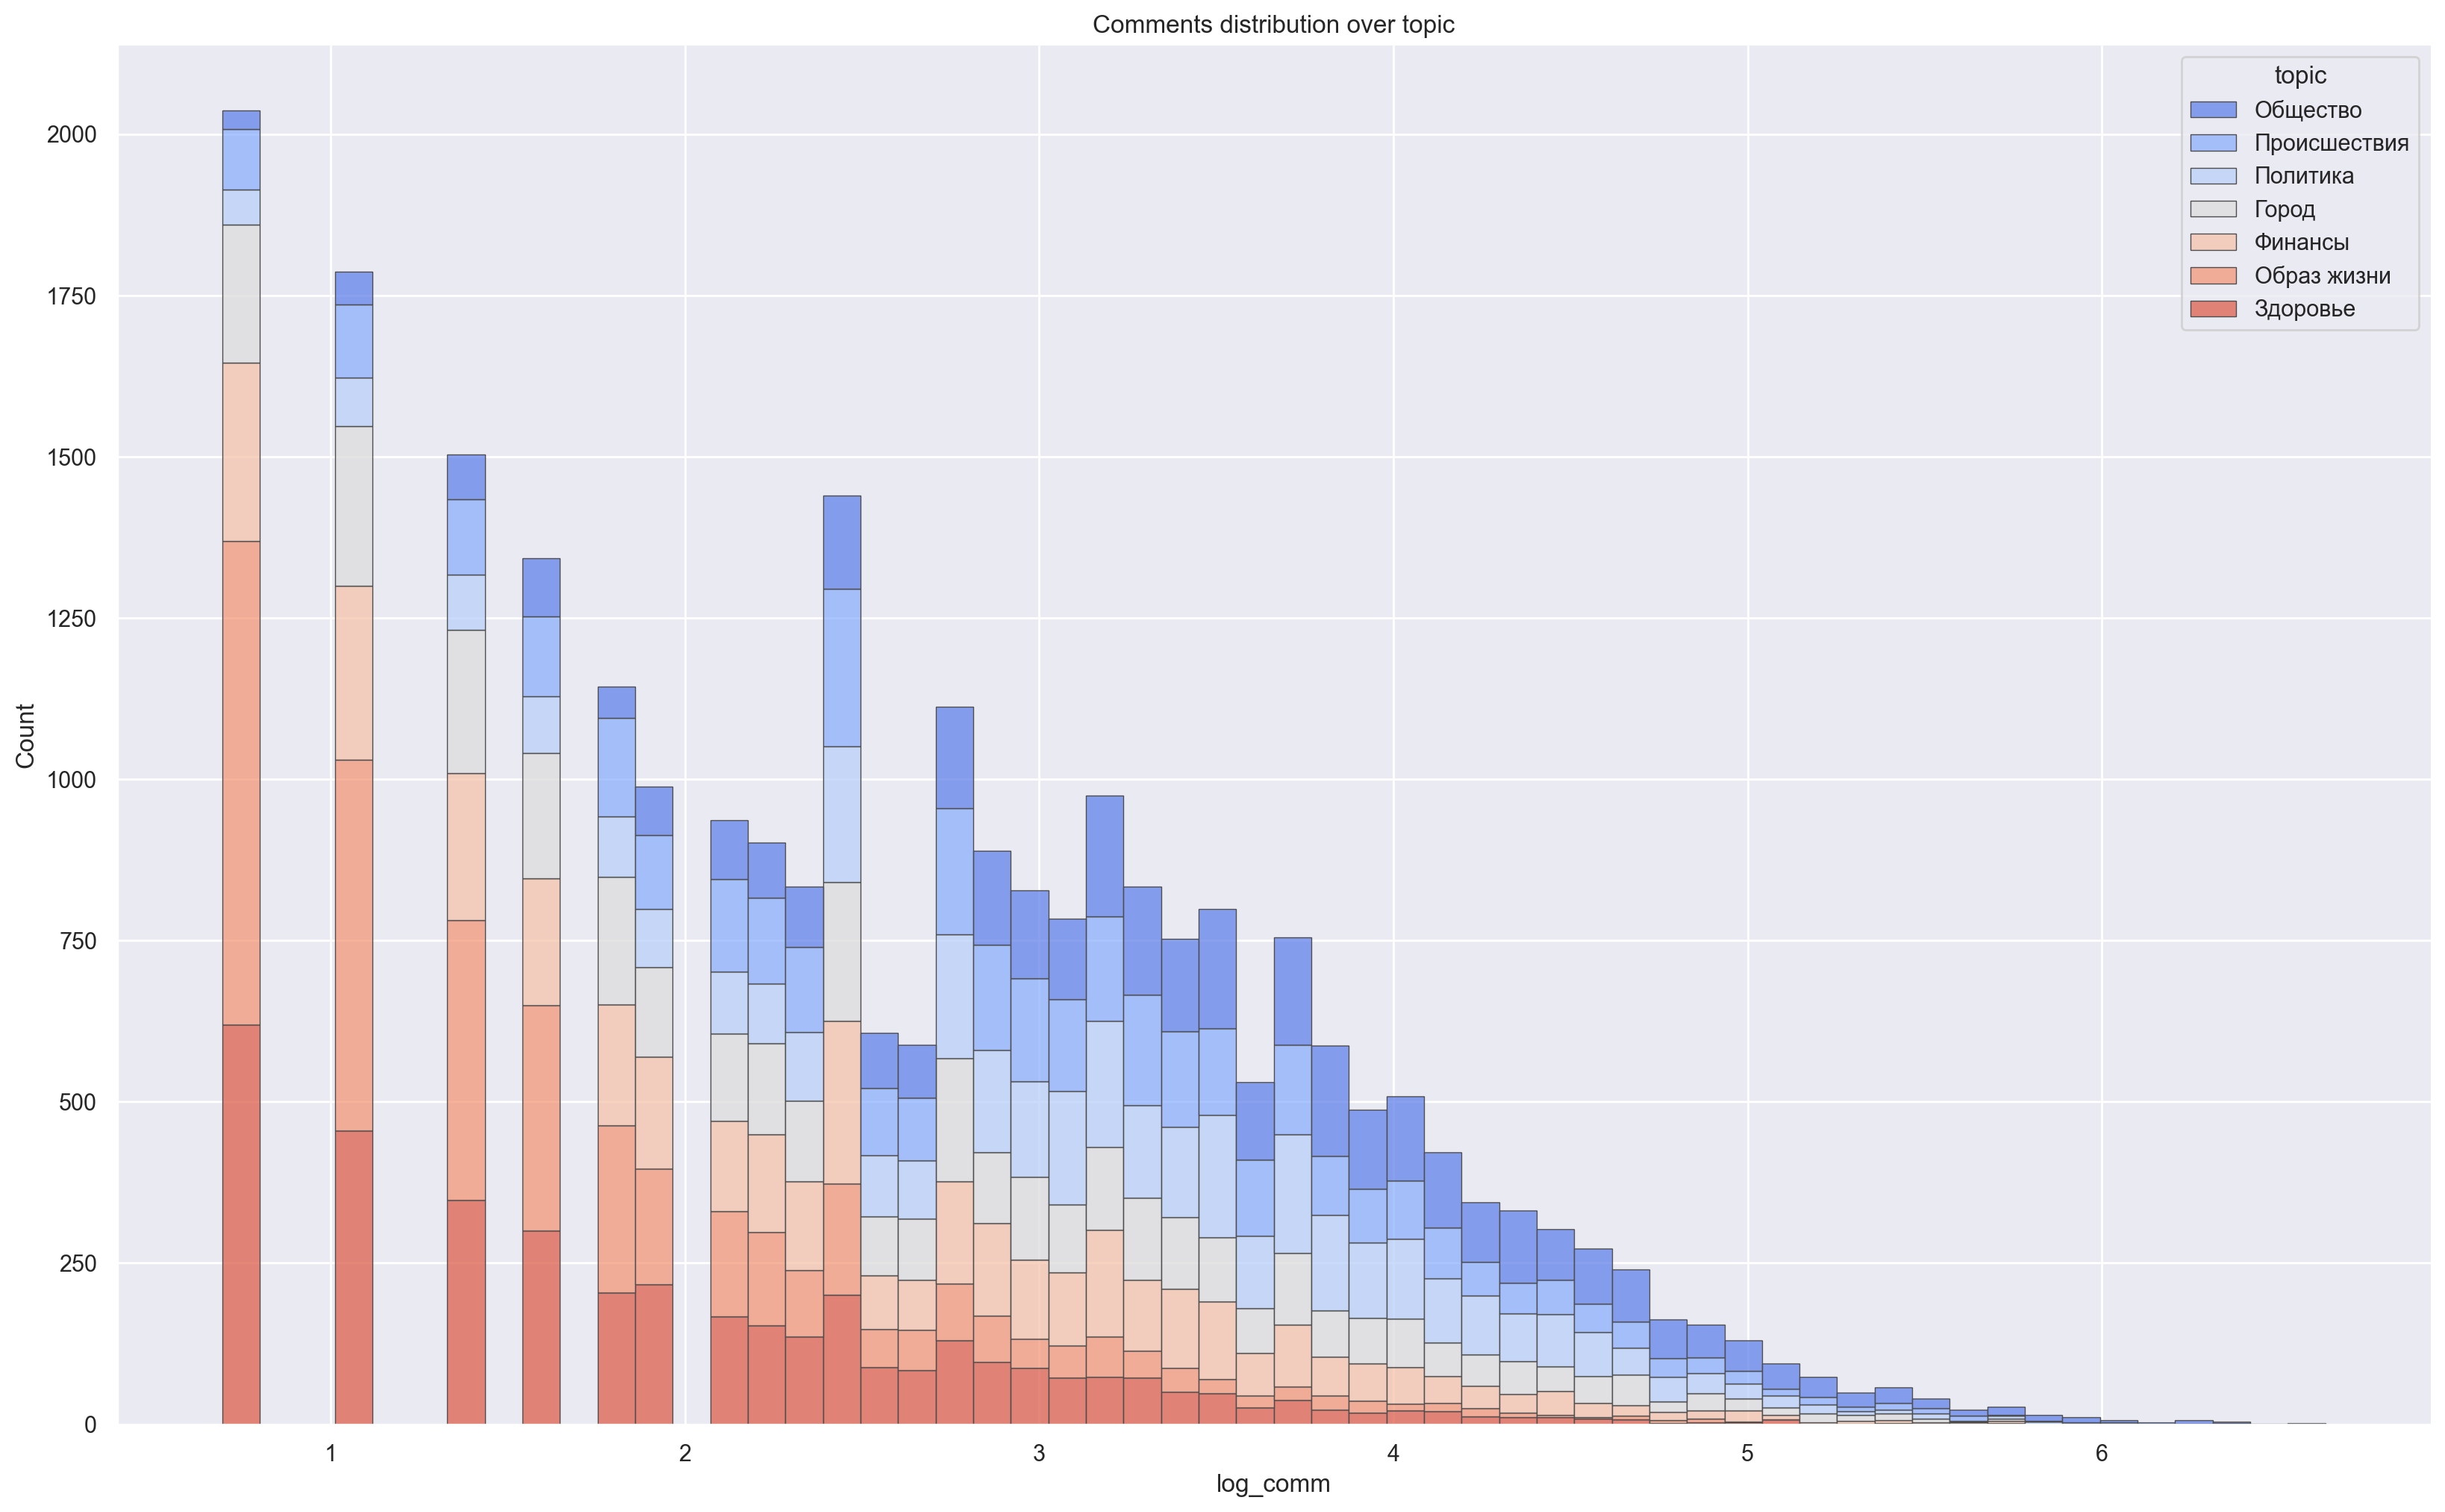

In [198]:
fig, axs = plt.subplots(1, 1, figsize=(20, 12), dpi=200)
sns.despine(fig)

sns.histplot(
    data,
    x="log_comm",
    hue="topic",
    multiple="stack",
    edgecolor=".3",
    palette="coolwarm",
    linewidth=.5,
);
axs.set_title('Comments distribution over topic');

In [199]:
# Generate a sample from a normal distribution with the same mat. expectation and variance, like our variable
x = np.random.normal(loc=data['log_comm'].mean(), scale=data['log_comm'].std(), size=100000)

# The Mann-Whitney test and p-significance
U1, p = mannwhitneyu(x, data['log_comm'])

print('P-significance:', p)

# Decision limit is 1%
if p < 0.01:
    print('The distribution of the number of views can be considered lognormal')
else:
    print('The distribution of the number of views cant be considered lognormal')

P-significance: 0.07380270327680968
The distribution of the number of views cant be considered lognormal


Let's look at the column with news authors

In [202]:
data.author.value_counts()

Неопознанный          14153
Женя Авербах           1720
Виктория Трофимова     1037
Федор Данилов           758
Кира Черных             693
                      ...  
Сергей Рукшин             1
Алиса Степанцова          1
Евгений Вдовин            1
Светлана Талипова         1
Борис Вишневский          1
Name: author, Length: 184, dtype: int64

In [203]:
data.shape

(26719, 16)

We see that out of 26719 news items, 12566 do not have a correspondent’s name, which is almost a half. It may be necessary to abandon this feature in the future.

Let's see which keywords are most often found in articles on each topic. One of the hypotheses is that articles on different but similar topics with the same keywords can make a negative contribution to the work of the model.

In [204]:
stop_words = stopwords.words('russian')
stop_words.extend(['что', 'это', 'так',
                    'вот', 'быть', 'как',
                    'в', '—', 'к', 'за', 'из', 'из-за',
                    'на', 'ок', 'кстати',
                    'который', 'мочь', 'весь',
                    'еще', 'также', 'свой',
                    'ещё', 'самый', 'ул', 'комментарий',
                    'английский', 'язык', 'Наш', 'наш',
                    'наш проект', 'которых', 'которые',
                    'проект', 'которым', ' проект'])

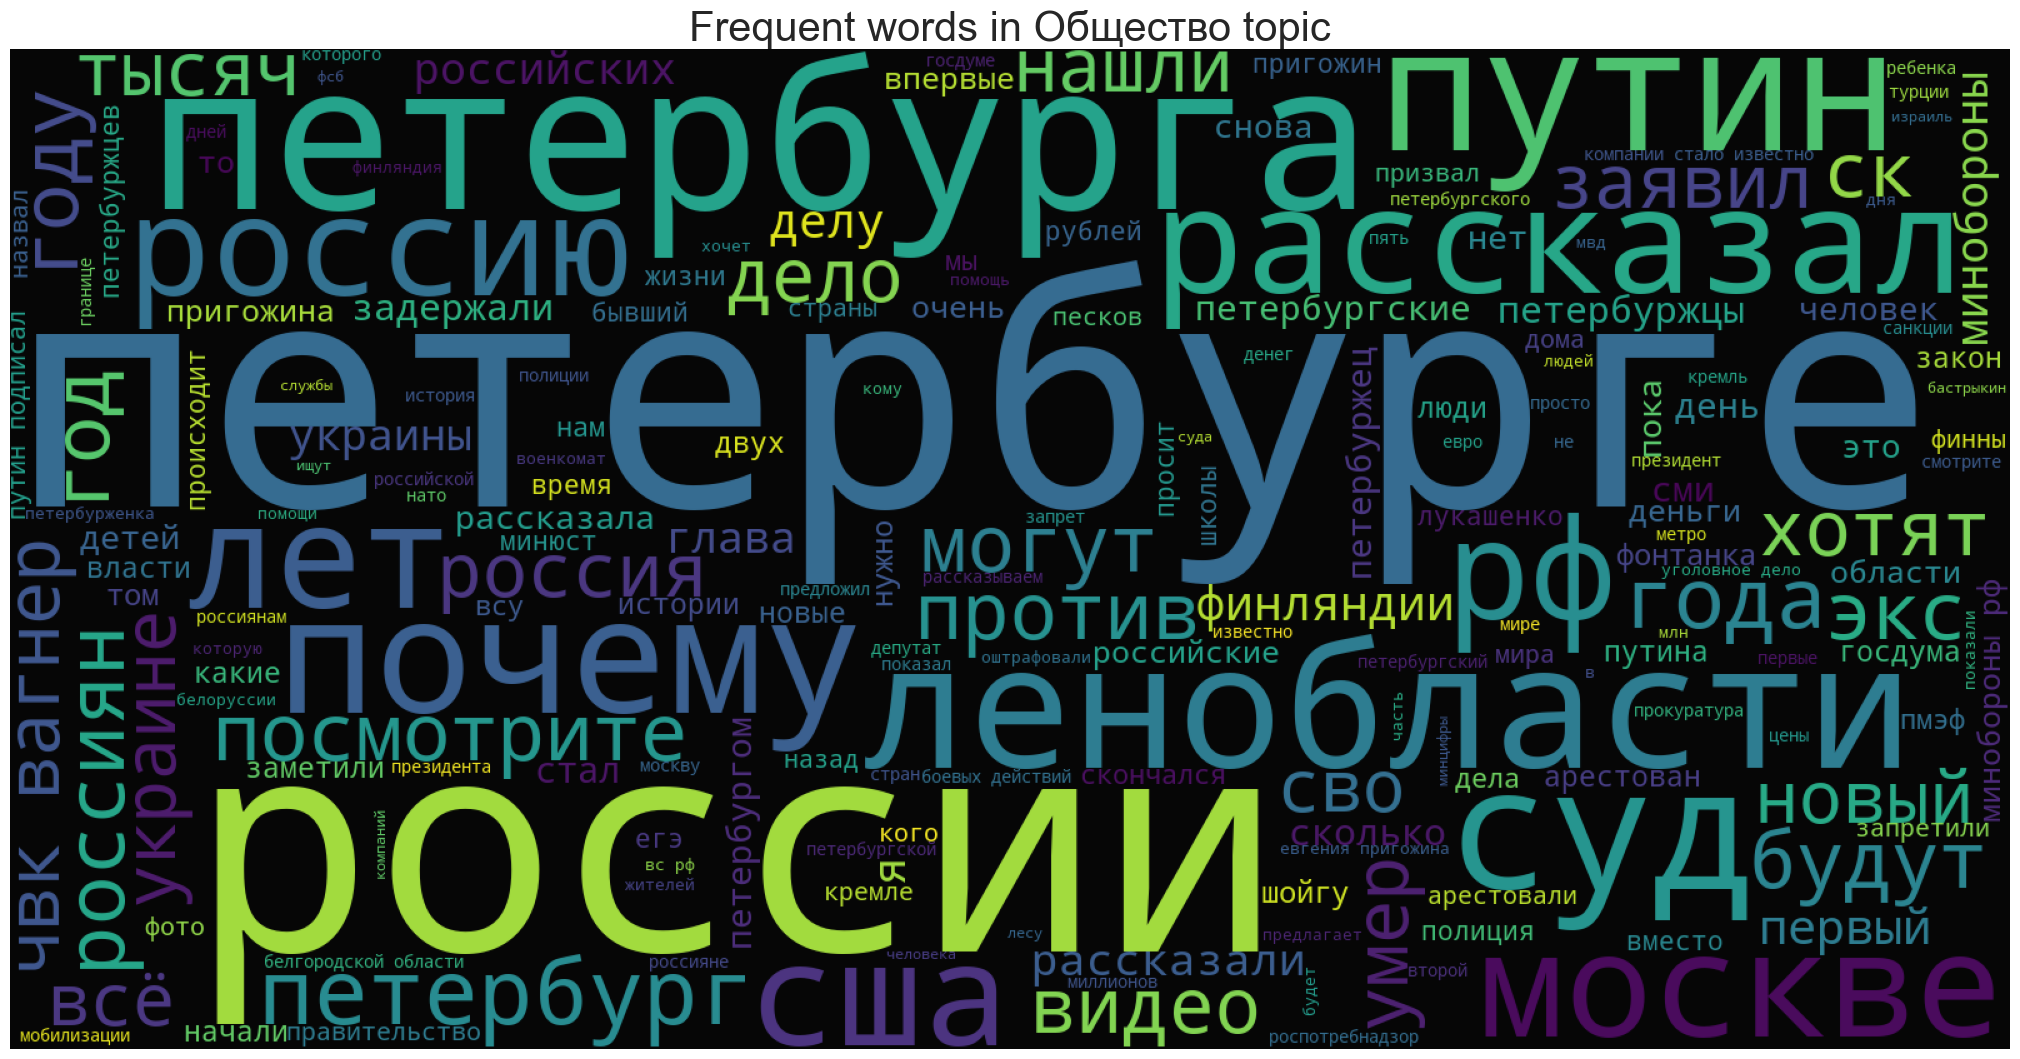

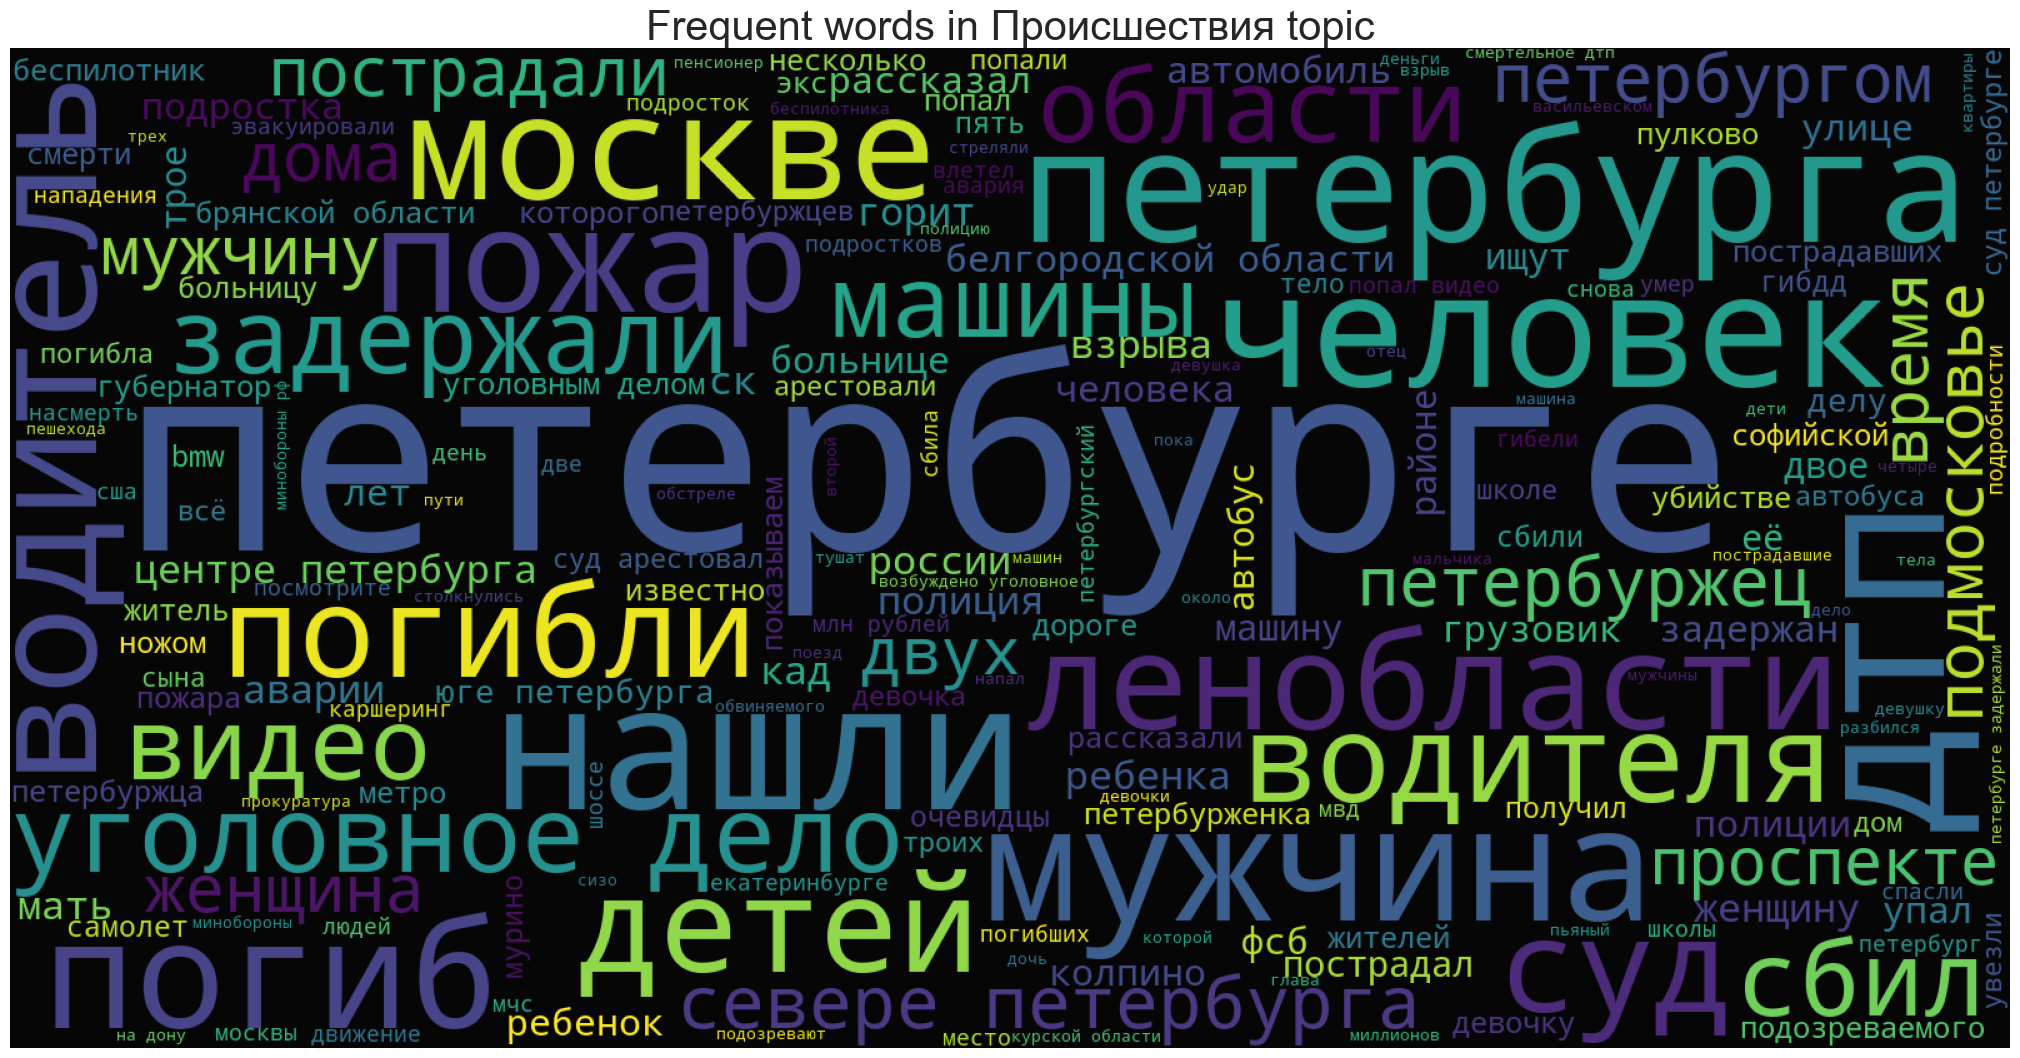

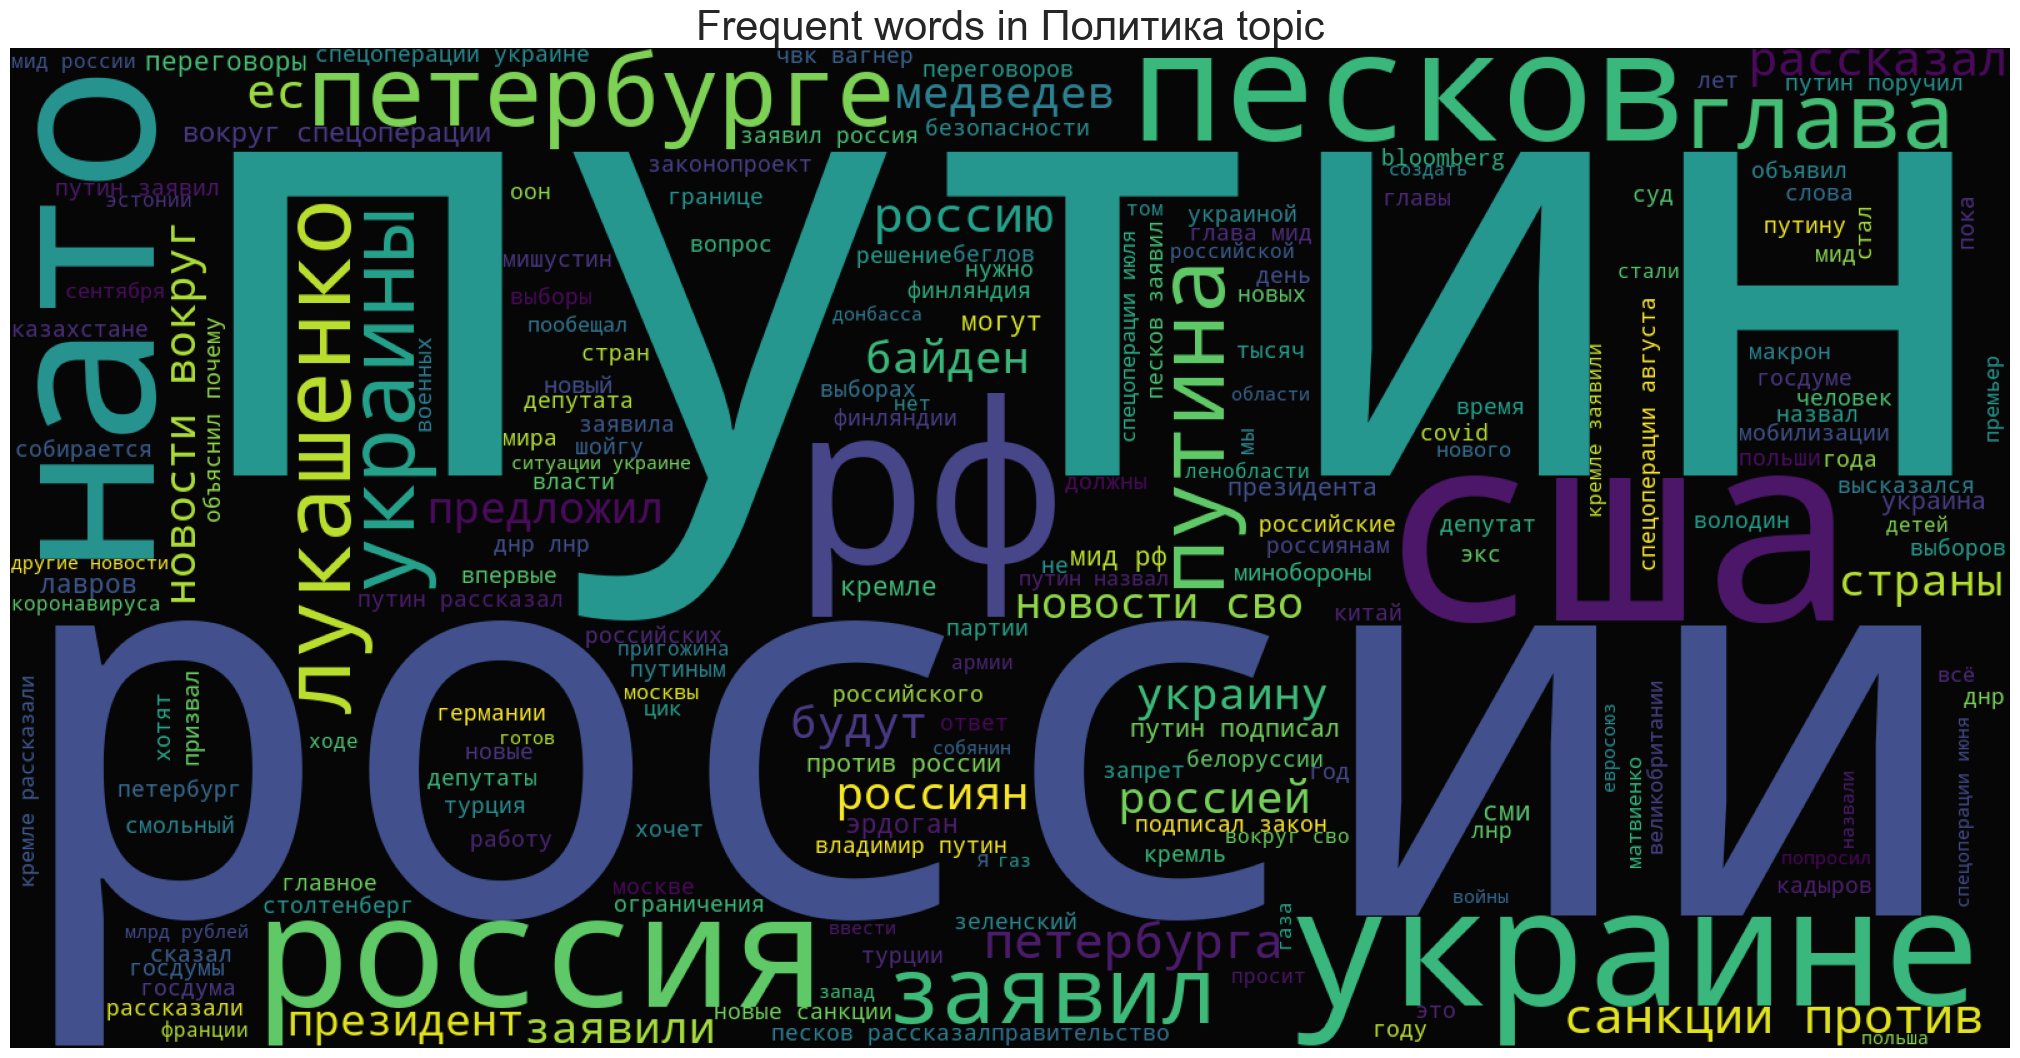

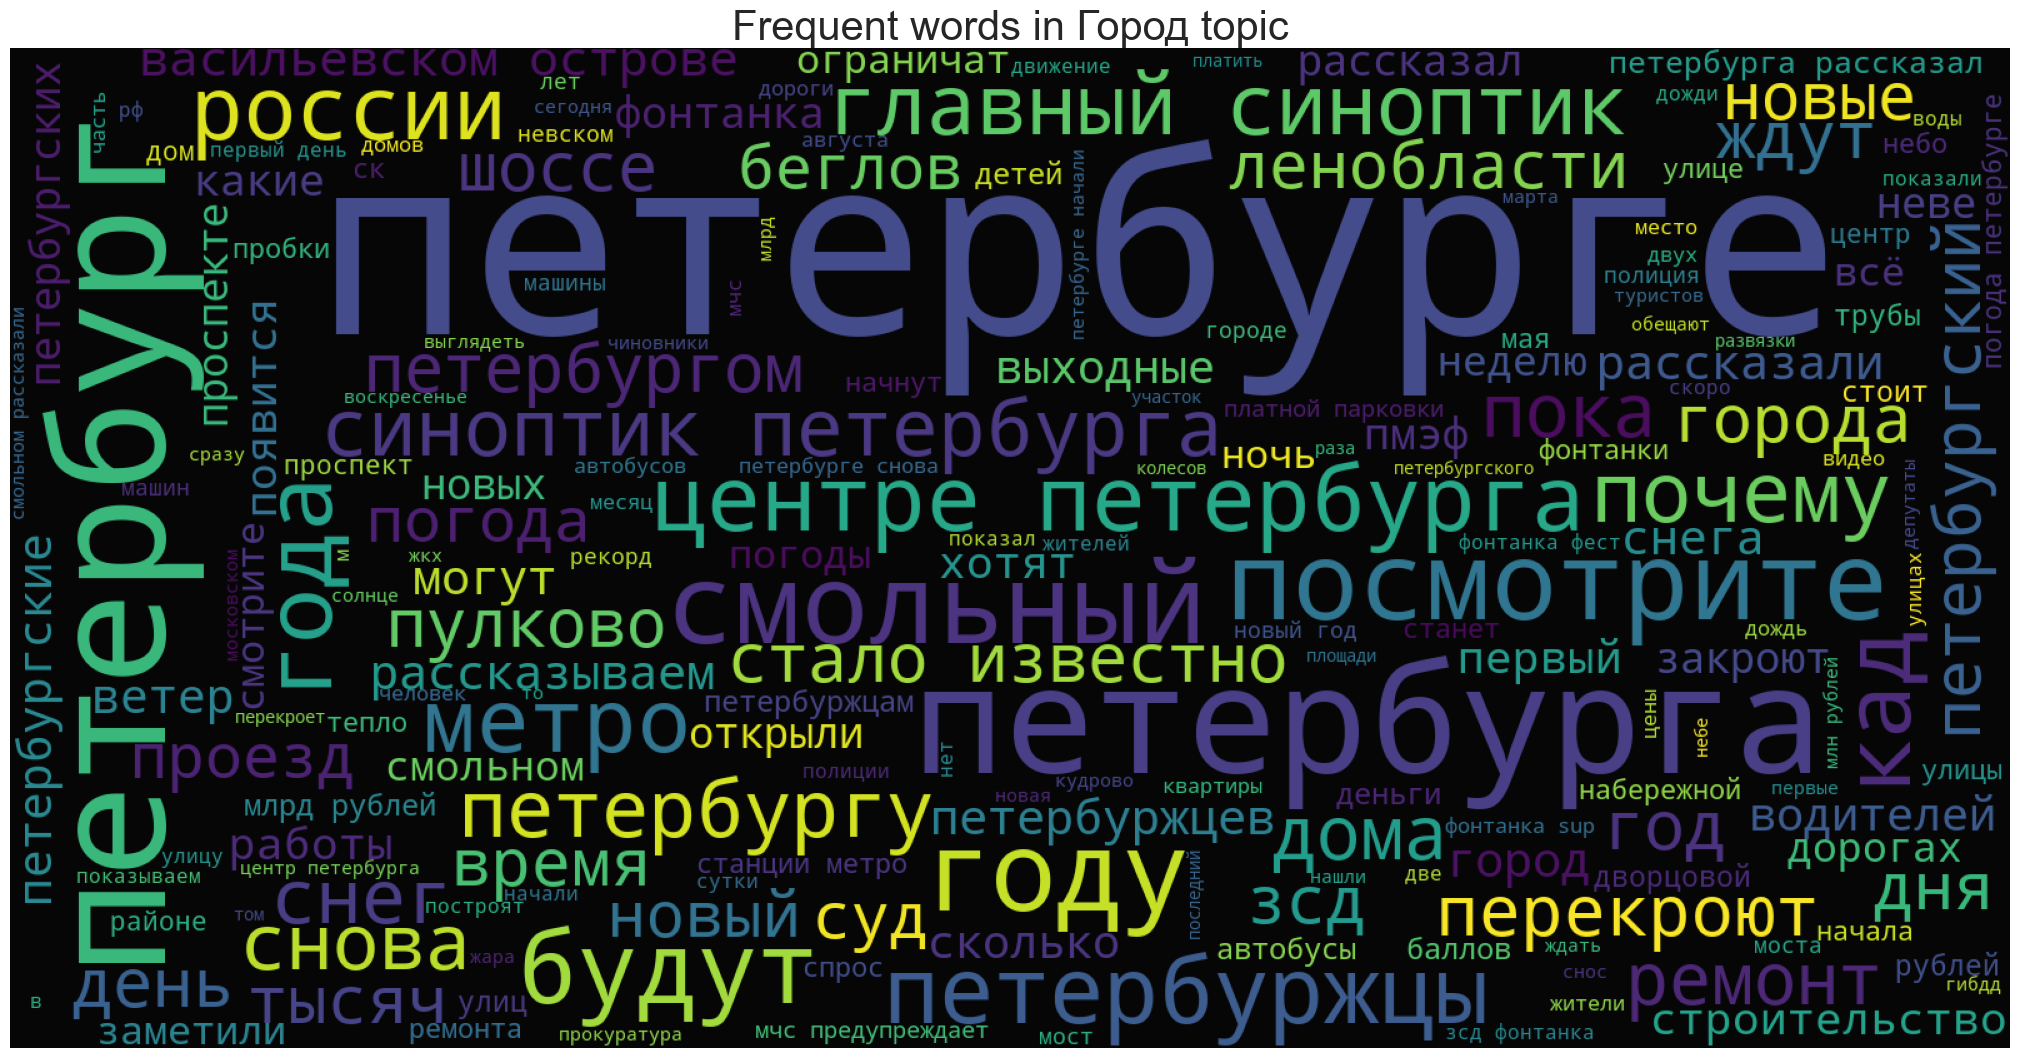

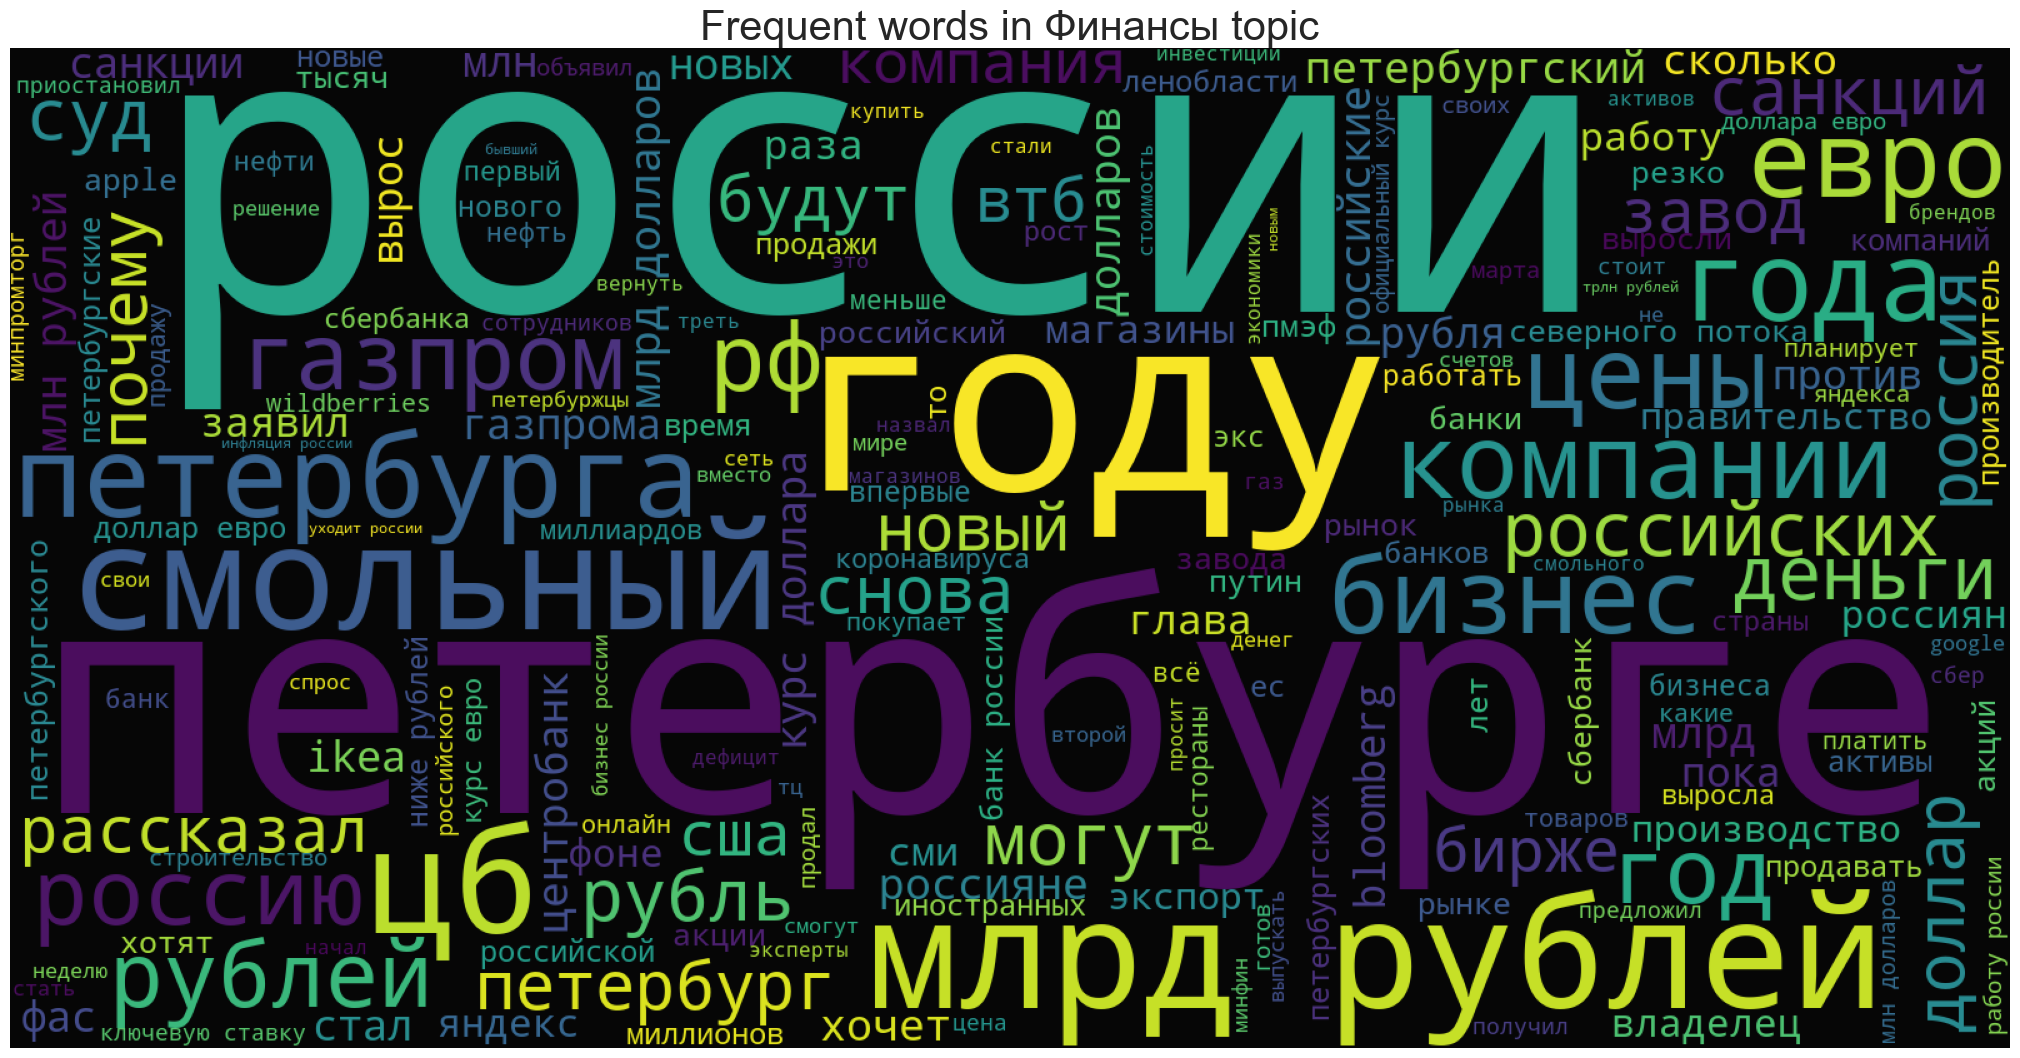

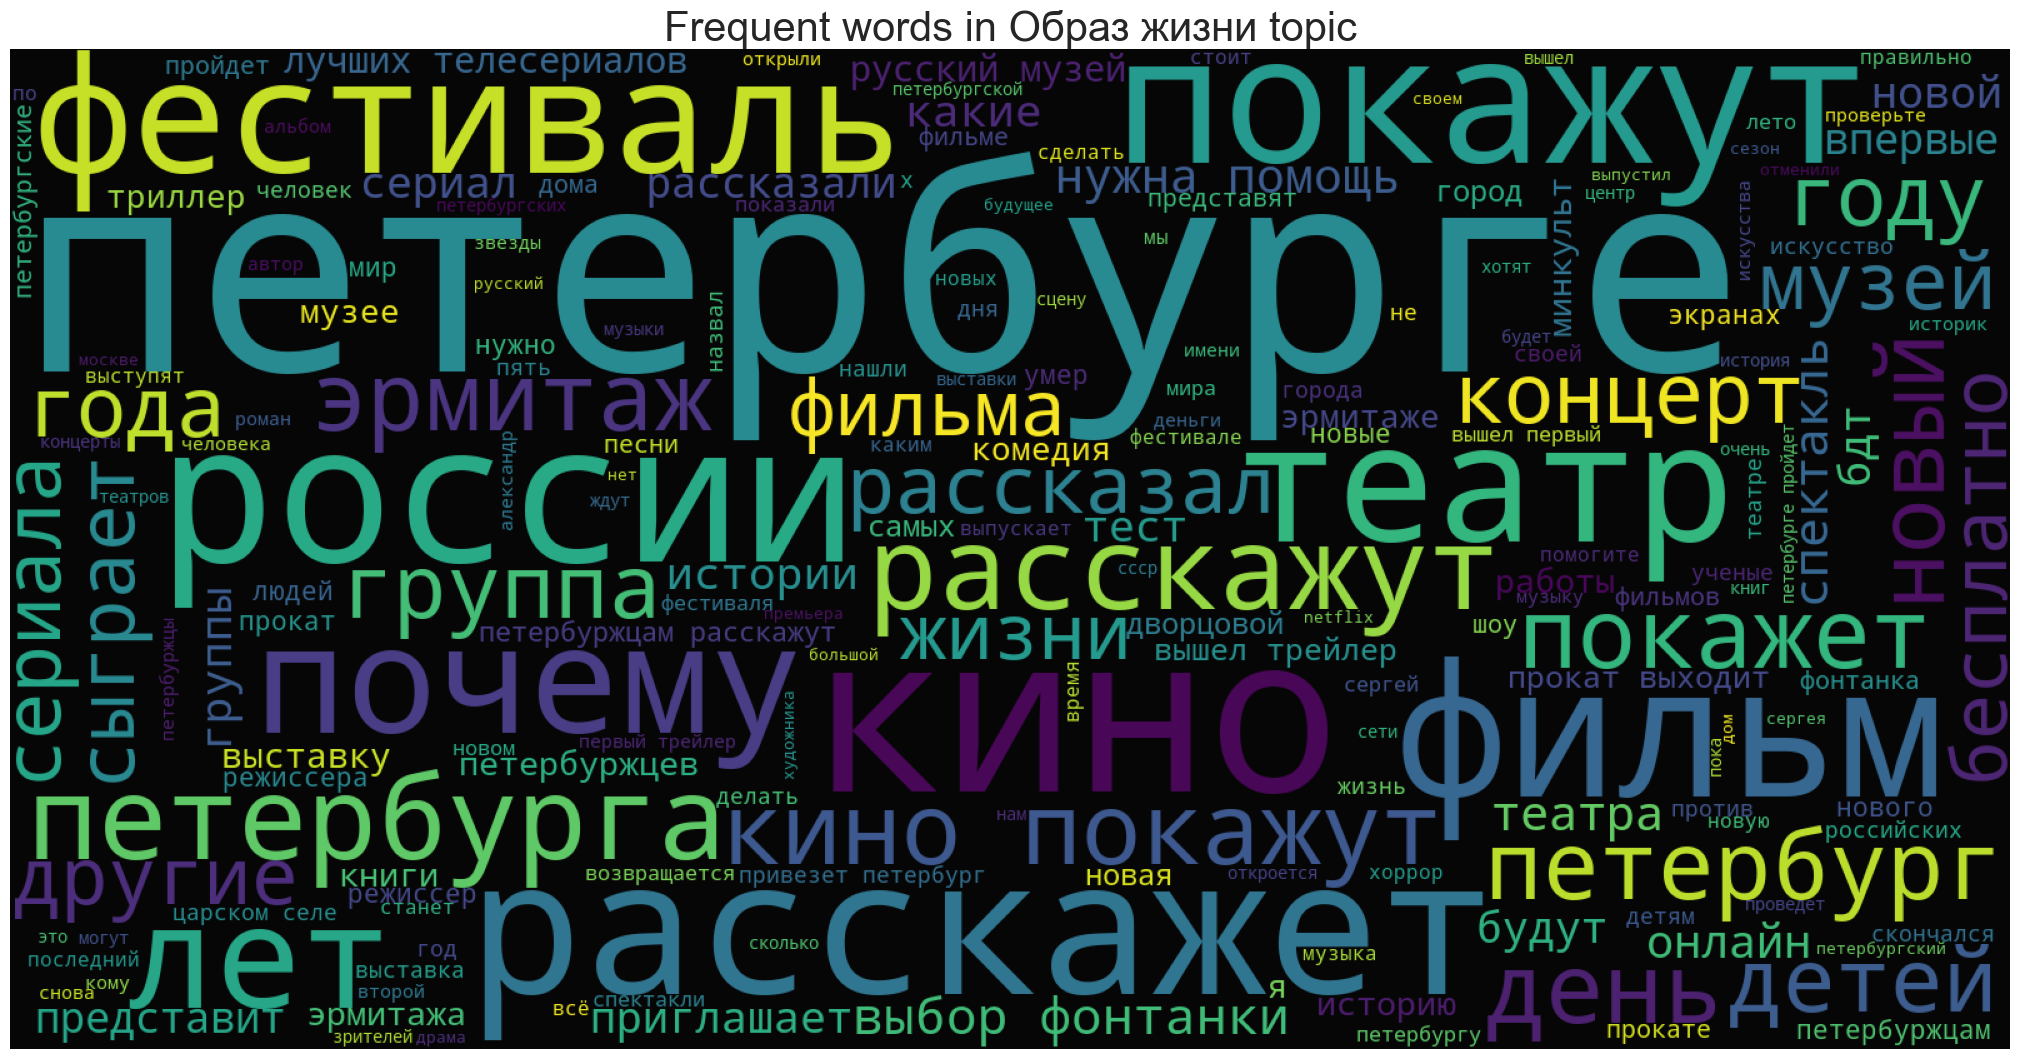

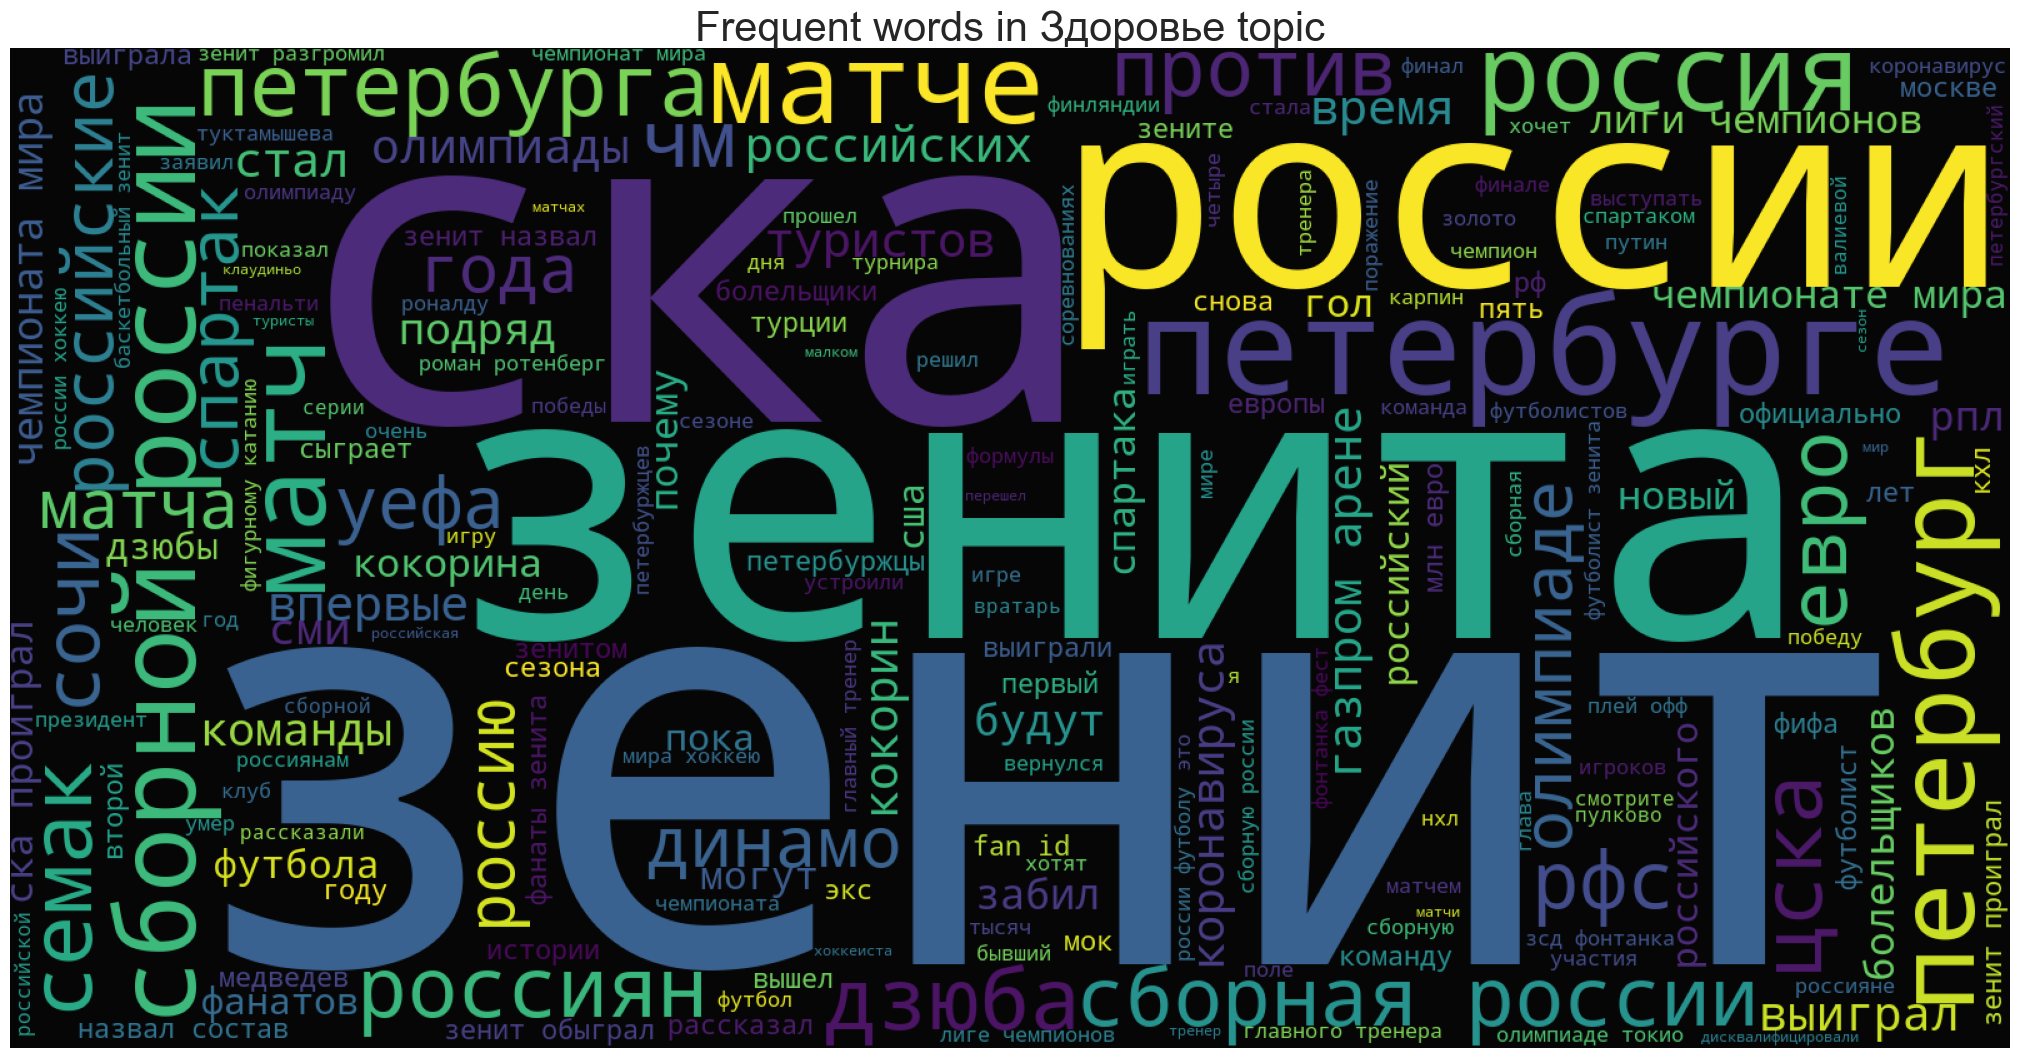

In [205]:
for topic in data.topic.unique():
    words = data[data.topic == topic].title.str.split(' ').explode().values
    words = [word.lower() for word in words if word.lower() not in stop_words]

    wc = WordCloud(background_color="black", width=1600, height=800)
    wc.generate(" ".join(words))

    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    plt.axis("off")
    plt.tight_layout(pad=0)
    ax.set_title(f"Frequent words in {topic} topic", fontsize=30)
    ax.imshow(wc, alpha=0.98)


We are currently uploading articles in reverse chronological order. This means that the sample includes both old and completely new articles. This greatly affects one of the signs - the number of views. Therefore, for the model to work correctly, it will be necessary to somehow normalize this feature. To do this, first look at the distribution of the age of articles, and then the distribution of the ratio of the number of views to the age of the article. This will not be such a correct assessment, because the number of views does not grow linearly over time. Most likely, this dependence is exponential in nature with a certain saturation line - an asymptote. But for the zero approximation, let's first try to consider the simplest option.

In [206]:
data['lifetime'] = data['date'].apply(lambda x: (datetime.datetime.now() - x).total_seconds())
data['lifetime'] = data['lifetime'].apply(lambda x: divmod(x, 60)[0]) # lifetime in minutes

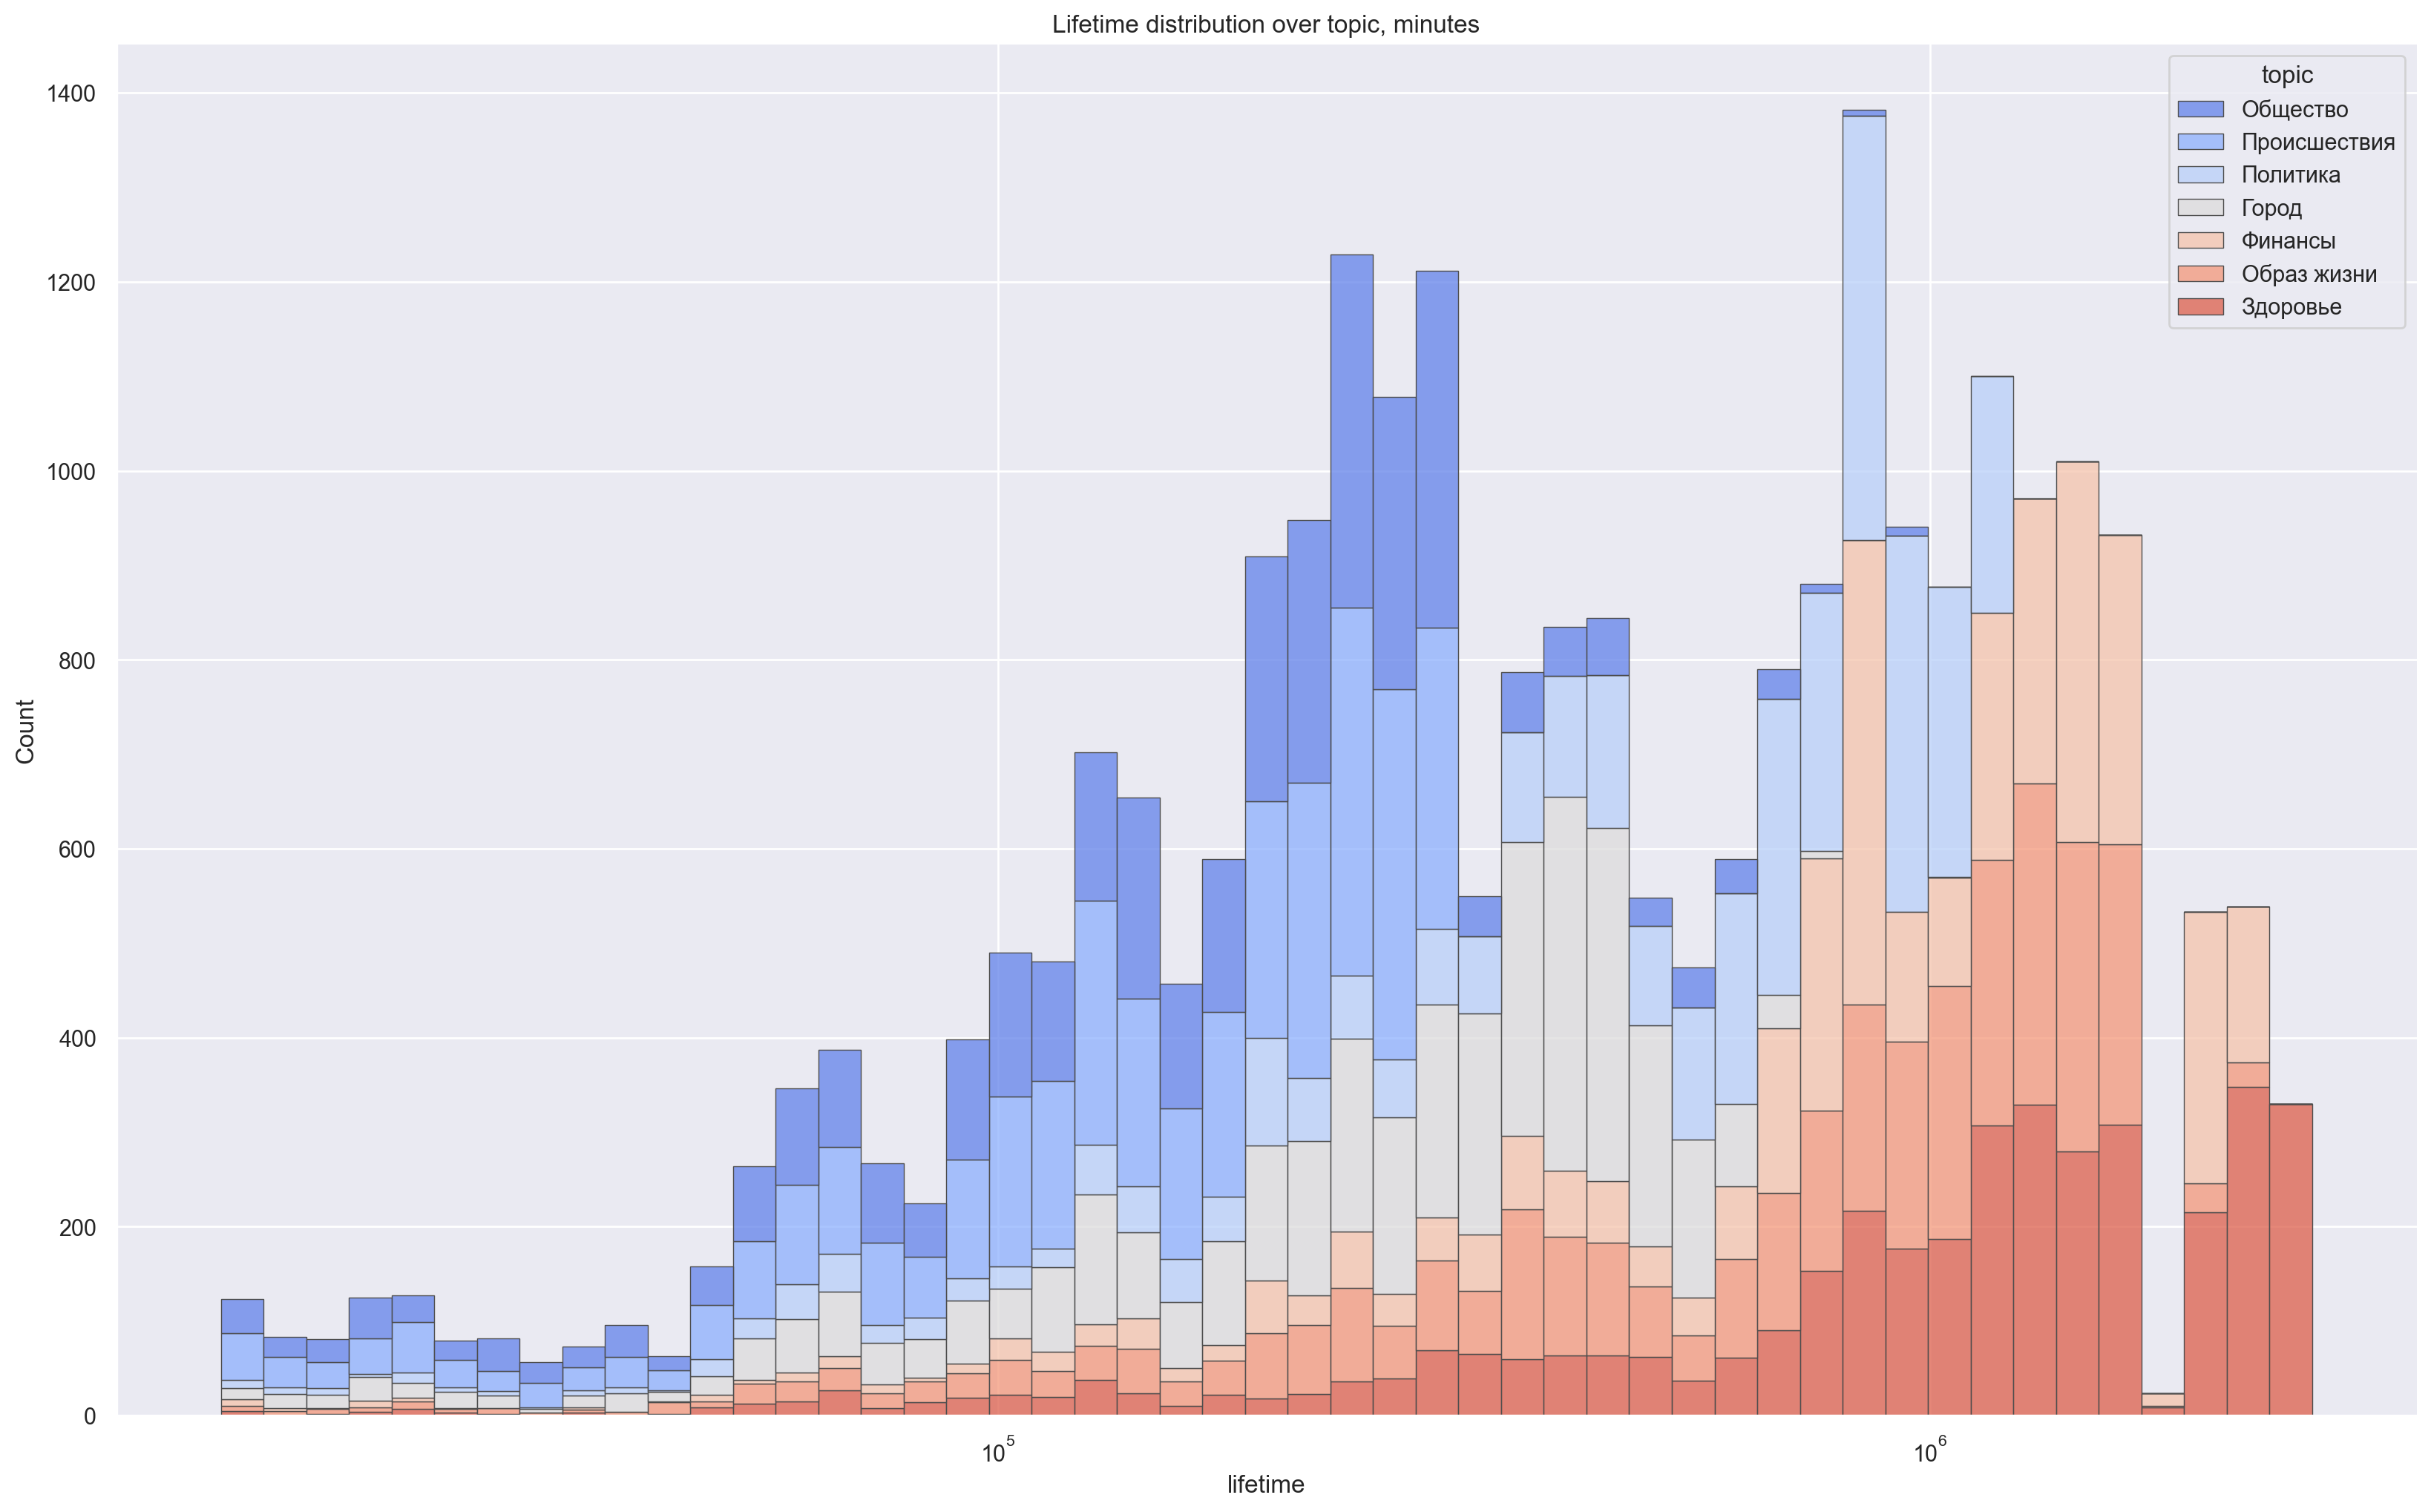

In [207]:
fig, axs = plt.subplots(1, 1, figsize=(20, 12), dpi=200)
sns.despine(fig)

sns.histplot(
    data,
    x="lifetime",
    hue="topic",
    multiple="stack",
    edgecolor=".3",
    palette="coolwarm",
    linewidth=.5,
    log_scale=True,
);
axs.set_title('Lifetime distribution over topic, minutes');

As expected, the dataset contains both old and new articles. And the distribution itself has a rather ambiguous shape.

In [208]:
data['views_by_minutes'] = (data['views'] + 1) / data['lifetime']

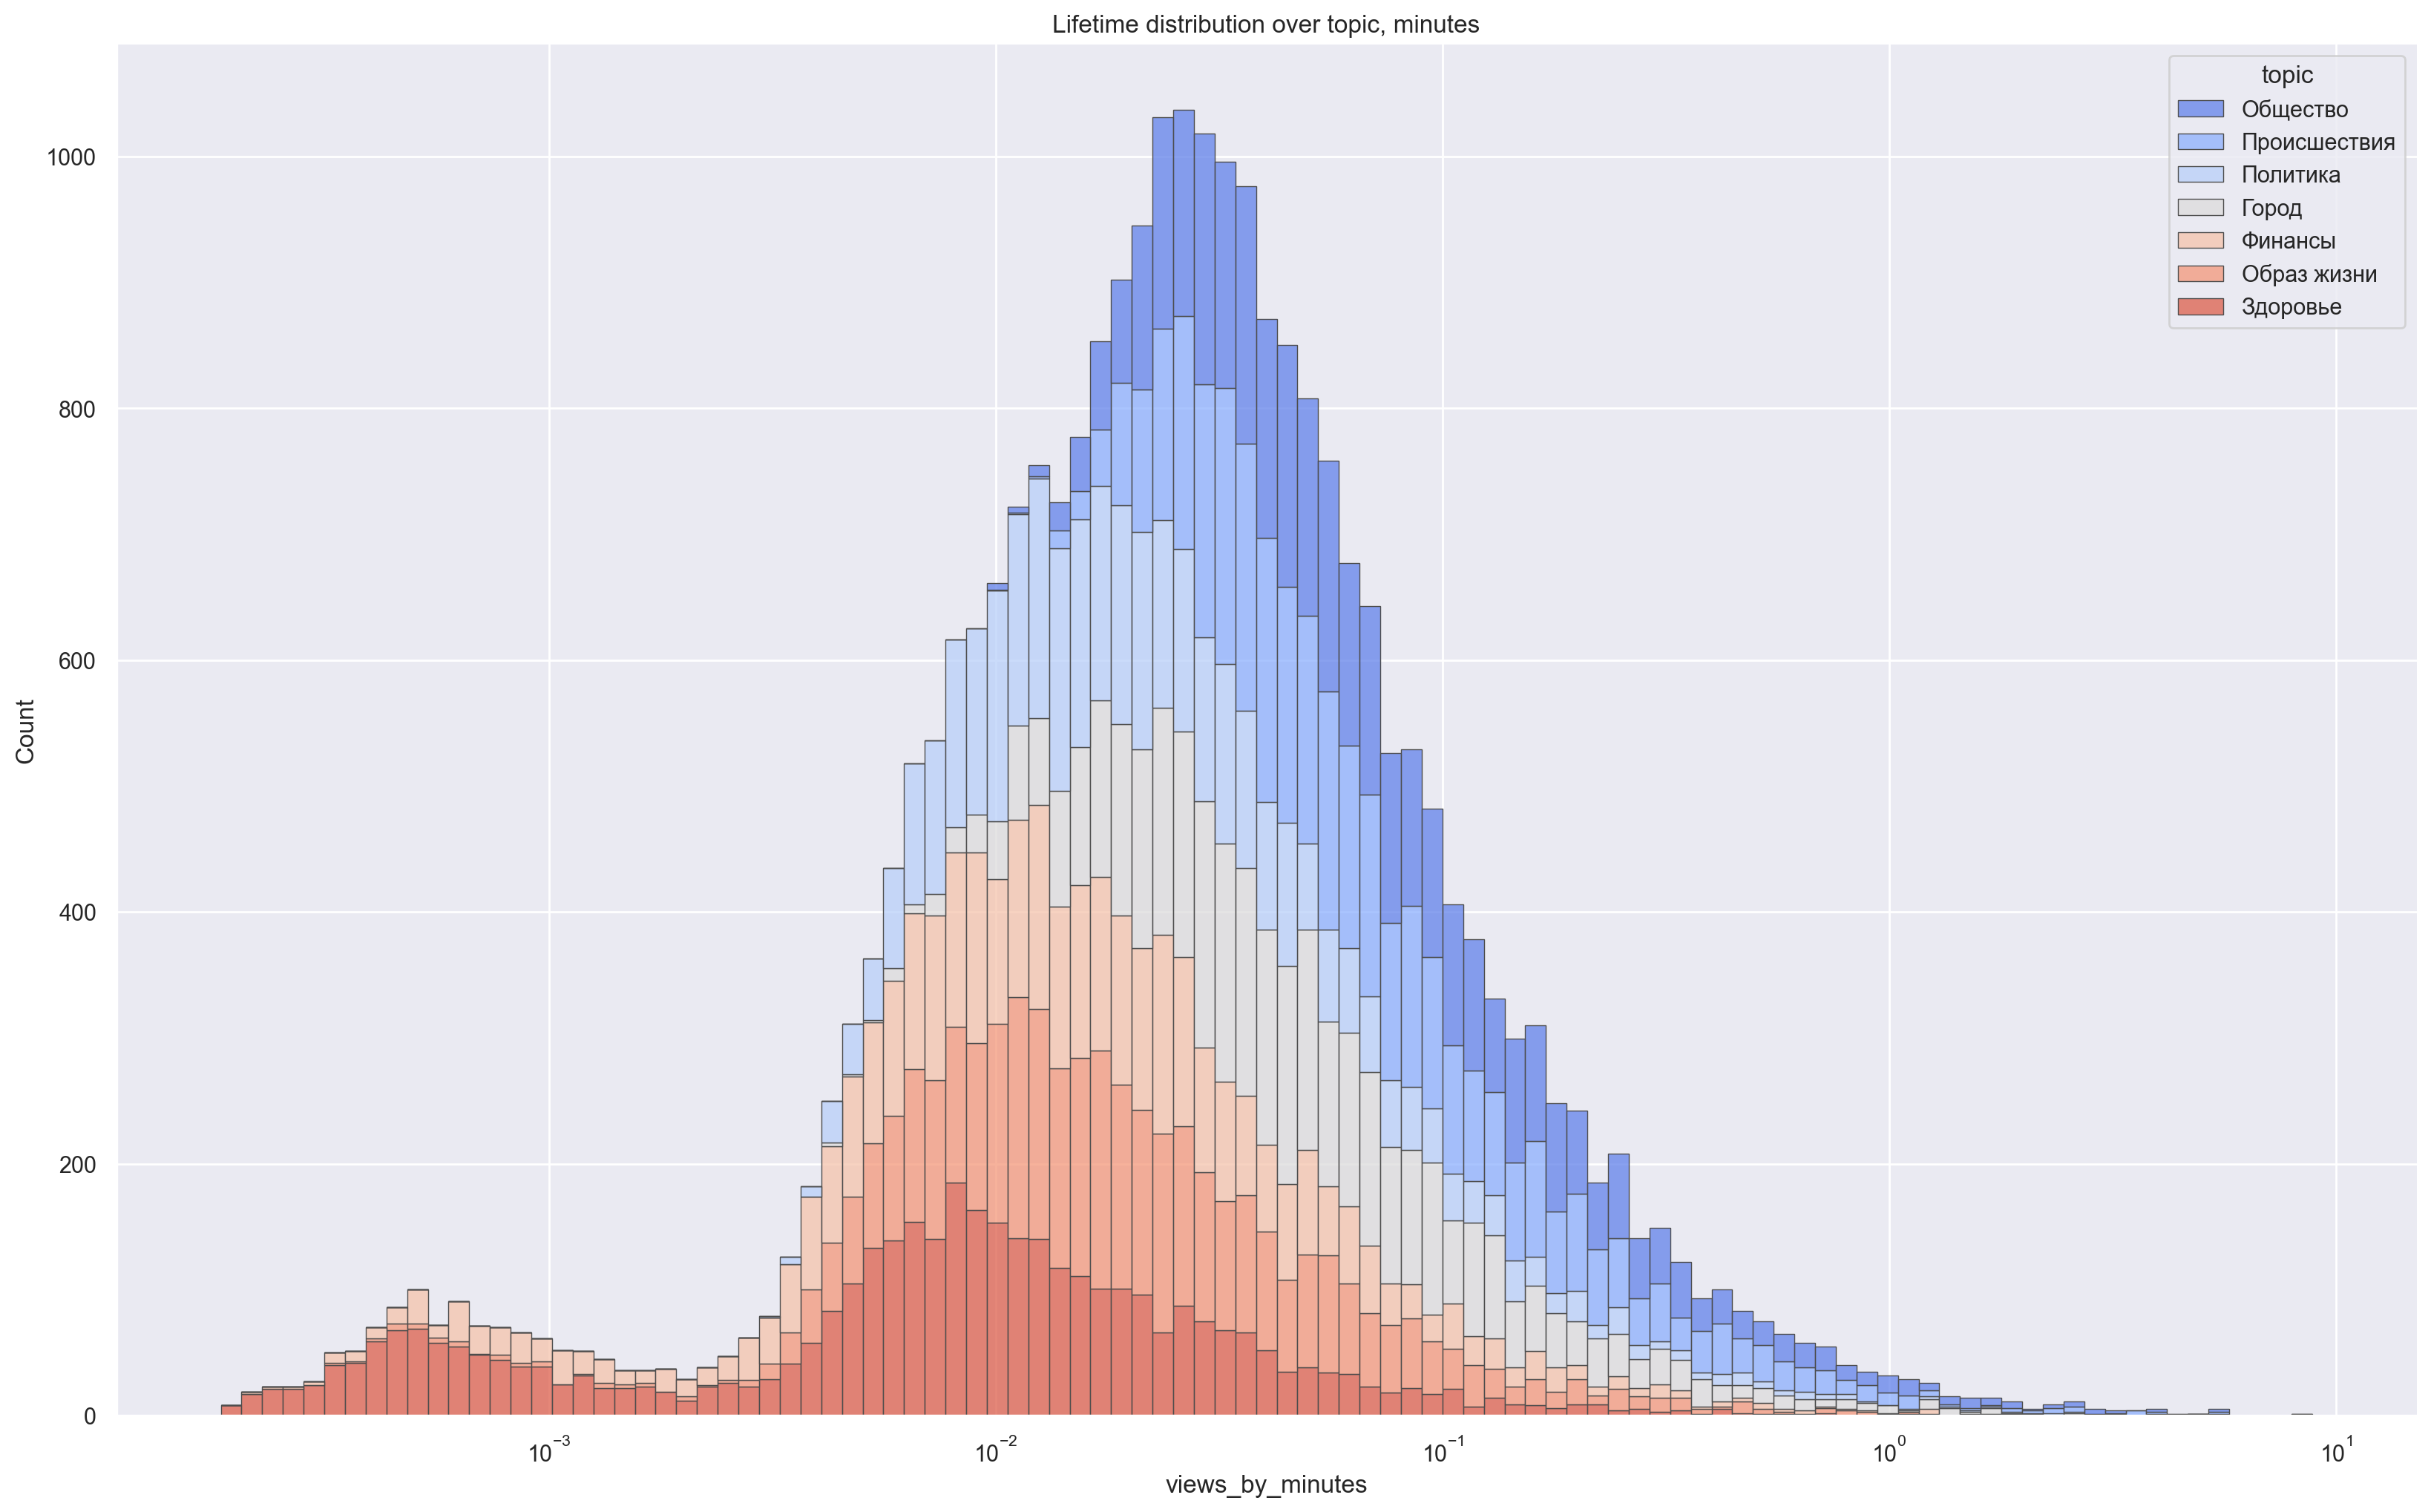

In [209]:
fig, axs = plt.subplots(1, 1, figsize=(20, 12), dpi=200)
sns.despine(fig)

sns.histplot(
    data,
    x="views_by_minutes",
    hue="topic",
    multiple="stack",
    edgecolor=".3",
    palette="coolwarm",
    linewidth=.5,
    log_scale=True,
);
axs.set_title('Lifetime distribution over topic, minutes');

The new feature - the number of views per minute, or the average growth rate of the number of views - already has a distribution close to lognormal, but with a serious tail at the beginning.

#### Saving the final dataset

In [80]:
data.to_csv('final_data.csv', index=False)

## Findings

So, at this stage we conducted an exploratory analysis of the dataset. The articles are distributed evenly across topics. Most of the news is from 2023, but there are also entries from 2018-2022. Most news was published in early autumn (August, September), and the least amount of news was published in winter. The least amount of news comes out on weekends and most on weekdays (classes are balanced on weekdays).

The average length of a news title is about 80 characters, but it has heavy tails, for example in the “Образ жизни” topic.
The average comment length for a news post is about 20 characters, but it also has heavy tails, for example in the “Происшествия” topic, which is logical.

We also analyzed the top keywords, which suggests that articles from different topics may be very similar in their dominant keywords and thus negatively influence the model. This will need to be kept in mind when building the model. For example, in all topics the word “Петербург” and its variations have a huge influence; this is the specificity of the news portal.

Not all articles have information about the author (almost half have no information), so in the future we will exclude it from the features.

One of the important, at first glance, signs is the number of views, since in each period of time the most popular articles will be on topics that are relevant for a given period of time. However, the number of views strongly depends on the age of the article, so we added a new feature - the average growth rate of the number of views - to check the normality of its distribution. Unfortunately, the Mann-Whitney test showed that this distribution is not lognormal. This can also be seen from the graph.

We also checked the distribution of the number of comments, and also did not get a lognormal distribution. It looks more like an exponential distribution.

Since we are working with texts, at this stage it is not yet so obvious which data and for what reason should be considered outliers, and which should be considered features of a specific topic. Therefore, we will leave this for the next stages of work on the project.